In [27]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
from tqdm import tqdm
import cv2
import tifffile
from skimage.transform import resize
import tensorflow as tf
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Conv2D, Reshape, Input, Conv2DTranspose
from keras.layers import Activation, LeakyReLU, BatchNormalization, Dropout, Resizing
import dcgan as dcgan
import wgan as wgan
import prgan as prgan
from scores import scores
from scores import preprocess_array

try:
    from tensorflow.keras.optimizers import Adam
except:
    from keras.optimizers import Adam



In [2]:
NOISE_DIM = 100  
BATCH_SIZE = 20 
STEPS_PER_EPOCH = 100
EPOCHS = 50
STEPS = 5
SEED = 40
WIDTH, HEIGHT, CHANNELS = 75, 75, 2
OPTIMIZER = Adam(0.0002, 0.5)

In [3]:
train = pd.read_json('./data/train.json')
train['inc_angle'] = pd.to_numeric(train['inc_angle'],errors='coerce')

In [4]:
def get_stats(train,label=1):
    train['max'+str(label)] = [np.max(np.array(x)) for x in train['band_'+str(label)] ]
    train['maxpos'+str(label)] = [np.argmax(np.array(x)) for x in train['band_'+str(label)] ]
    train['min'+str(label)] = [np.min(np.array(x)) for x in train['band_'+str(label)] ]
    train['minpos'+str(label)] = [np.argmin(np.array(x)) for x in train['band_'+str(label)] ]
    train['med'+str(label)] = [np.median(np.array(x)) for x in train['band_'+str(label)] ]
    train['std'+str(label)] = [np.std(np.array(x)) for x in train['band_'+str(label)] ]
    train['mean'+str(label)] = [np.mean(np.array(x)) for x in train['band_'+str(label)] ]
    train['p25_'+str(label)] = [np.sort(np.array(x))[int(0.25*75*75)] for x in train['band_'+str(label)] ]
    train['p75_'+str(label)] = [np.sort(np.array(x))[int(0.75*75*75)] for x in train['band_'+str(label)] ]
    train['mid50_'+str(label)] = train['p75_'+str(label)]-train['p25_'+str(label)]

    return train
train = get_stats(train,1)
train = get_stats(train,2)

In [5]:
def plot_var(name,nbins=50):
    minval = train[name].min()
    maxval = train[name].max()
    plt.hist(train.loc[train.is_iceberg==1,name],range=[minval,maxval],
             bins=nbins,color='b',alpha=0.5,label='Boat')
    plt.hist(train.loc[train.is_iceberg==0,name],range=[minval,maxval],
             bins=nbins,color='r',alpha=0.5,label='Iceberg')
    plt.legend()
    plt.xlim([minval,maxval])
    plt.xlabel(name)
    plt.ylabel('Number')
    plt.show()

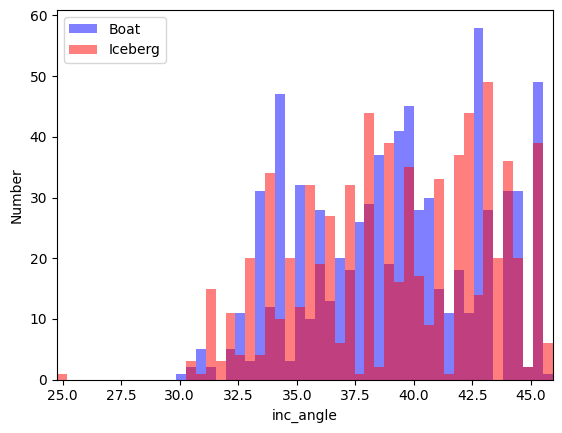

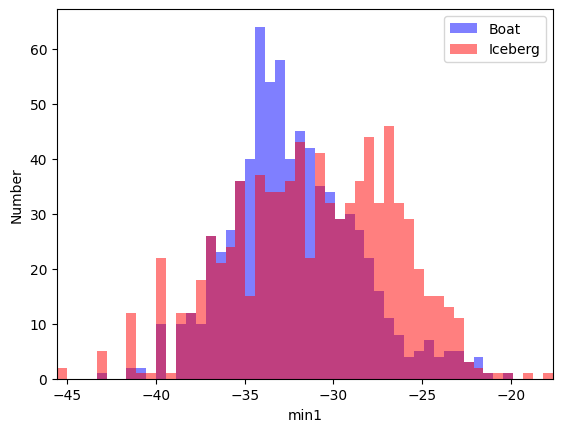

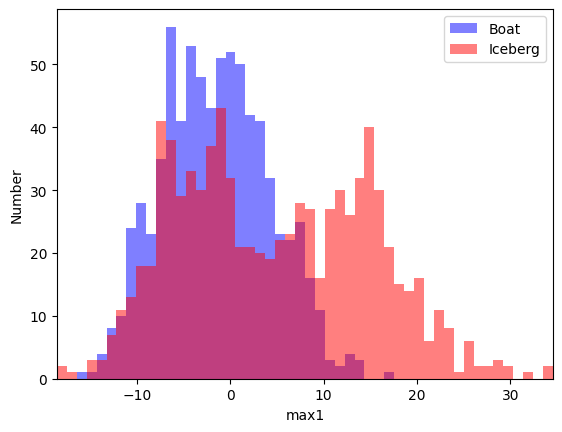

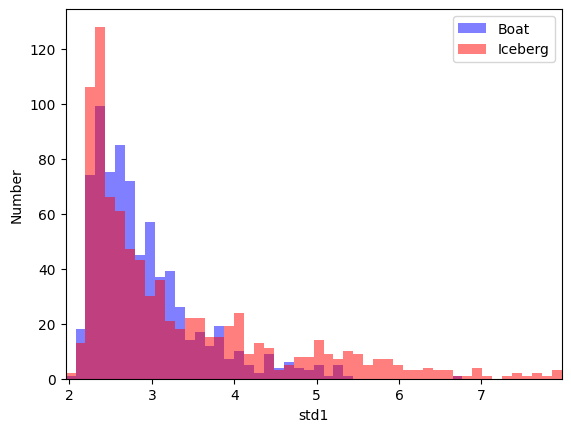

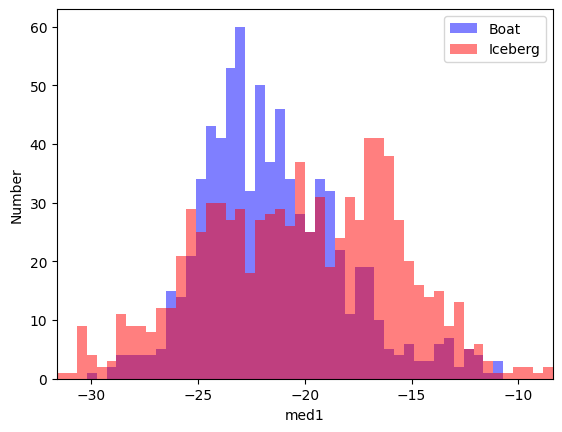

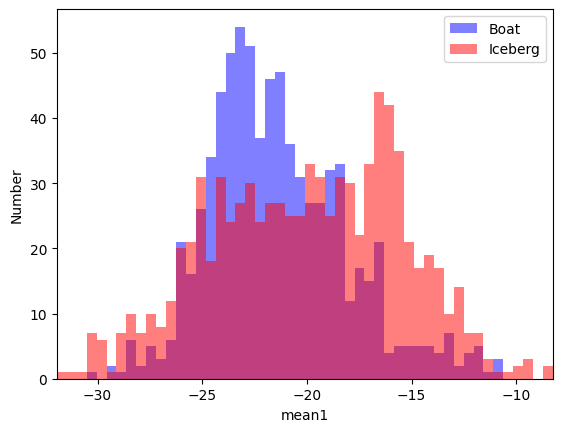

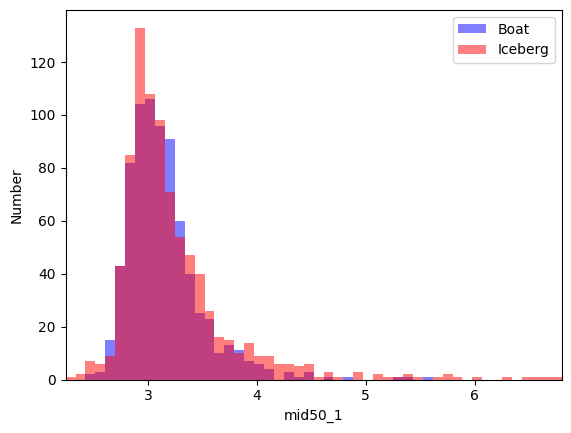

In [6]:
for col in ['inc_angle','min1','max1','std1','med1','mean1','mid50_1']:
    plot_var(col)

In [7]:
train_stats = train.drop(['id','is_iceberg','band_1','band_2'],axis=1)

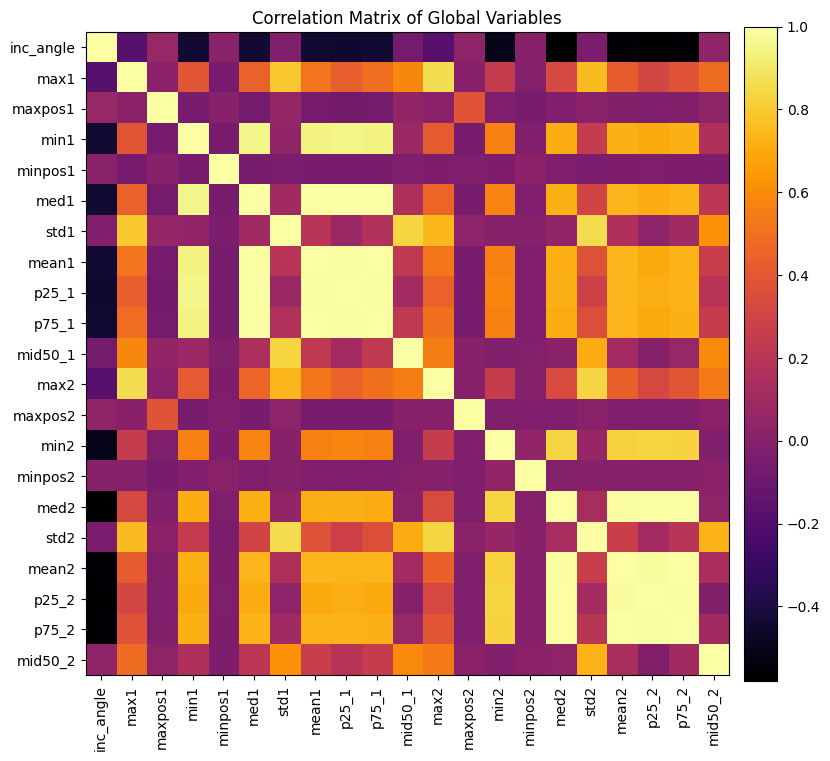

In [8]:
corr = train_stats.corr()
fig = plt.figure(1, figsize=(10,10))
plt.imshow(corr,cmap='inferno')
labels = np.arange(len(train_stats.columns))
plt.xticks(labels,train_stats.columns,rotation=90)
plt.yticks(labels,train_stats.columns)
plt.title('Correlation Matrix of Global Variables')
cbar = plt.colorbar(shrink=0.85,pad=0.02)
plt.show()

In [9]:
icebergs = train[train.is_iceberg==1].sample(n=300,random_state=123)
ships = train[train.is_iceberg==0].sample(n=300,random_state=456)

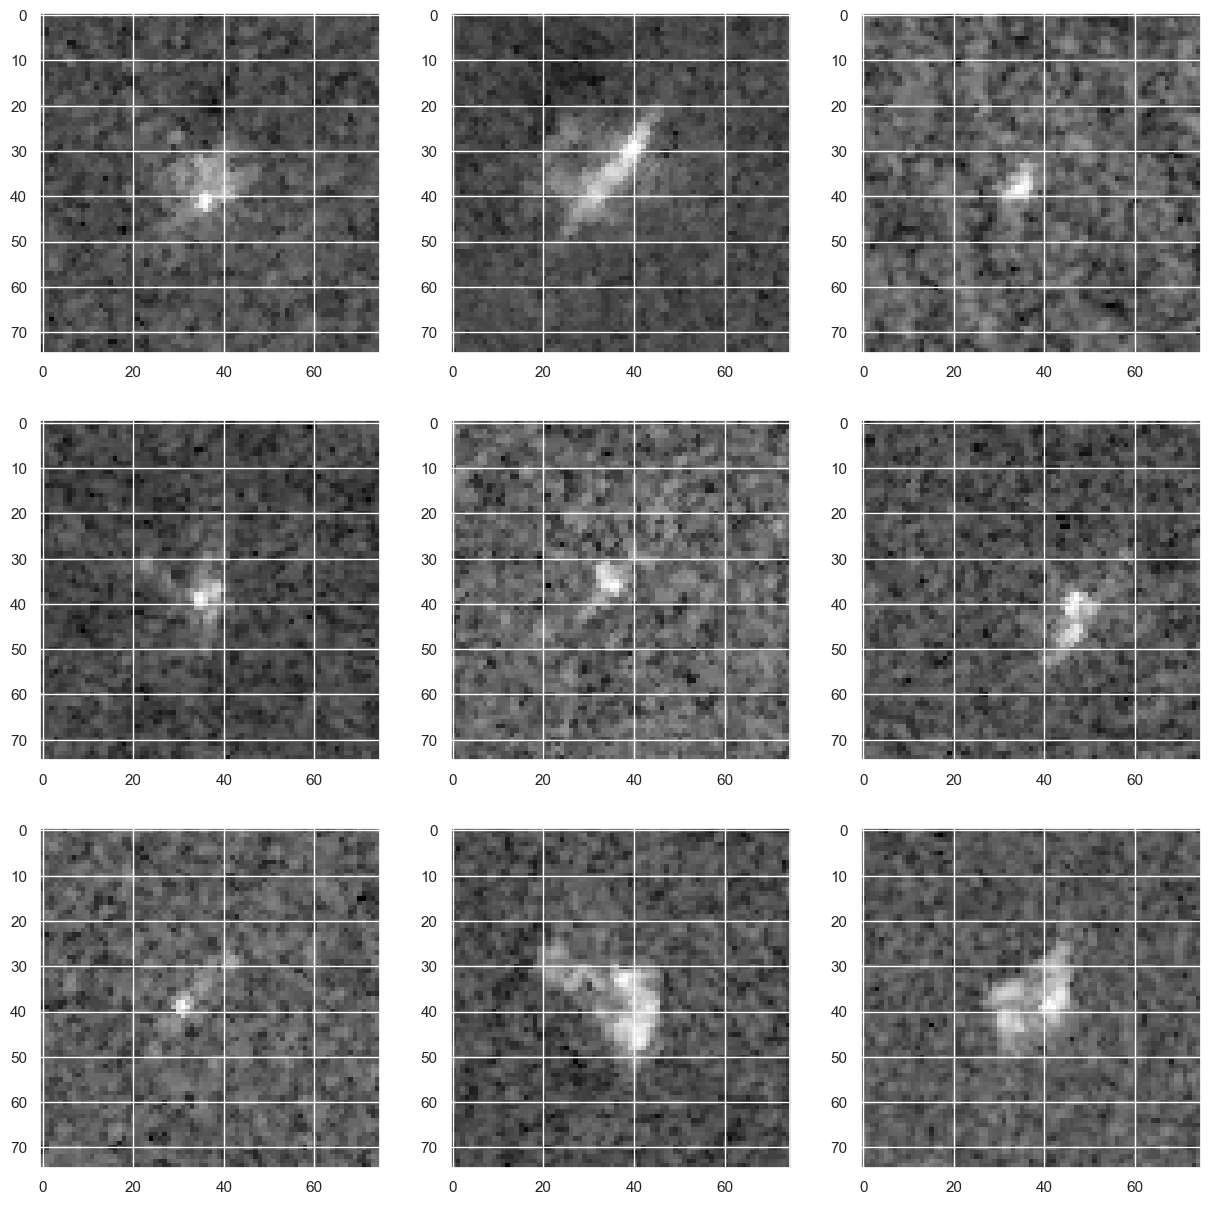

In [111]:
# Plot band_1/band_2 images
fig = plt.figure(1,figsize=(15,15))
for i in range(9):
    ax = fig.add_subplot(3,3,i+1)
    arr = np.reshape(np.array(icebergs.iloc[i,1]),(75,75))
    ax.imshow(arr,cmap='gist_gray')
    
plt.show()

In [11]:
def plot_results(images, n_cols=None):
    '''Visualizes fake images'''

    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1

    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)

    plt.figure(figsize=(n_cols * 2, n_rows * 2))  # Increase the figure size to accommodate 2-band images

    for index, image in enumerate(images):
        if image.shape[-1] == 1:
            image = np.squeeze(image, axis=-1)
        elif image.shape[-1] == 2:
            # Merge the two bands into a single image
            image = np.dstack((image[:, :, 0], image[:, :, 1]))
            image = np.mean(image, axis=2)  # Convert to grayscale by taking the mean of the two bands
        else:
            raise ValueError("Invalid number of image bands")

        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="inferno")
        plt.axis("off")


In [12]:
# download the training images
X_train = icebergs[['band_1', 'band_2']]
# Remove the first row (column names)
column_names = X_train.iloc[0]
X_train = X_train.iloc[1:]

column_1 = np.array([np.array(image) for image in X_train['band_1']])
column_2 = np.array([np.array(image) for image in X_train['band_2']])

column_1 = column_1.flatten().reshape(-1)
column_2 = column_2.flatten().reshape(-1)

mean_1 = np.mean(column_1)
std_1 = np.std(column_1)

mean_2 = np.mean(column_2)
std_2 = np.std(column_2)

normalized_column_1 = (column_1 - column_1.min()) / (column_1.max() - column_1.min())
normalized_column_2 = (column_2 - column_2.min()) / (column_2.max() - column_2.min())
#normalized_column_1 = (column_1 - mean_1) / std_1
#normalized_column_2 = (column_2 - mean_2) / std_2

X_train_normalized = np.column_stack((normalized_column_1, normalized_column_2))
#print(X_train[0])
# Reshape images 
X_train = X_train_normalized.reshape(-1, WIDTH,HEIGHT,CHANNELS)

# Convert X_train to a NumPy array
X_train_array = np.array(X_train)


print(X_train_array.shape)

# create batches of tensors to be fed into the model
dataset = X_train
print(X_train_array.dtype)

(299, 75, 75, 2)
float64


In [112]:
from scipy import ndimage

def sample_images(noise, subplots, generator, prefix, figsize=(22,8), save=False):
    generated_images = generator.predict(noise)
    print(generated_images.shape)
    

    plt.figure(figsize=figsize)
    #print(np.amax(generated_images))
    samples = []
    for i, image in enumerate(generated_images):
        plt.subplot(subplots[0], subplots[1], i+1)
        if CHANNELS == 1:
            plt.imshow(image.reshape((WIDTH, HEIGHT)), cmap='gray')    
                                                                            
        else:
            print(image.shape)
            if image.shape == (16, 16, 2):
                image = ndimage.zoom(image, (75 / 16, 75 / 16, 1), order=1)

            image_band1 = np.reshape(np.array(image[:, :, 1]),(75,75))
            plt.imshow(image_band1, cmap='gist_gray')

            #channel_1 = image[:, :, 0]
            #channel_2 = image[:, :, 1]

            #plt.subplot(1, 2, 1)
            #plt.imshow(channel_1, cmap='gray')
            #plt.title('Channel 1')

            #plt.subplot(1, 2, 2)
            #plt.imshow(channel_2, cmap='gray')
            #plt.title('Channel 2')

            #plt.show()
            import matplotlib.image
            #print(np.amin(image.reshape((WIDTH, HEIGHT, 3))))
            from skimage import util
            #image = (image - image.min()) / (image.max() - image.min())
            #print(np.min(image))   # minimum value of the image data
            #print(np.max(image))   # maximum value of the image data
            #matplotlib.image.imsave('gen_img'+str(i)+'.png', image)
            #image_data = np.transpose(image, (2, 0, 1))
            # Transpose the array to have shape (height, width, num_channels)
            #image_data = np.transpose(image, (2, 0, 1))
            #print(image.shape)
            # Concatenate the channels along the third axis to create a multi-channel image
            print(image.shape)
            joined_channels_image = np.concatenate([np.expand_dims(image[:, :, i], axis=0) for i in range(image.shape[2])], axis=0)
            joined_channels_image = np.transpose(joined_channels_image, (1, 2, 0))  # Transpose dimensions

            samples.append(joined_channels_image)
            combined_image = np.mean(joined_channels_image, axis=2)

            plt.imshow(combined_image, cmap='gist_gray')
            # Save grayscale image as PNG
            plt.imsave(prefix + '_gen_img' + str(i) + '.png', combined_image, cmap='inferno')

        if save == True:
            img_name = "gen" + str(i)
            plt.savefig(img_name)
        plt.subplots_adjust(wspace=None, hspace=None)
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    return samples

In [14]:
noise_dcgan = np.random.normal(0,1, size=(BATCH_SIZE, NOISE_DIM))
noise_wgan = tf.random.normal([32, 75*75*2])
generator_dcgan, discriminator_dcgan, dcgan_model = dcgan.build(OPTIMIZER, NOISE_DIM)
generator_dcgan_loss_values = dcgan.train(generator_dcgan, discriminator_dcgan, dcgan_model, noise_dcgan, EPOCHS, STEPS, BATCH_SIZE, NOISE_DIM, X_train_array)
generator_wgan, generator_wgan_loss_values = wgan.train(EPOCHS, STEPS, BATCH_SIZE, NOISE_DIM, X_train_array)




Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 75, 75, 64)        1216      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 75, 75, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 38, 38, 75)        43275     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 38, 38, 75)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 19, 19, 75)        50700     
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 19, 19, 75)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 10, 10, 75)    

  0%|          | 0/5 [00:00<?, ?it/s]

1/1 [==============================] - 0s 305ms/step


 20%|██        | 1/5 [00:02<00:08,  2.01s/it]

1/1 [==============================] - 0s 151ms/step


 40%|████      | 2/5 [00:02<00:03,  1.29s/it]

1/1 [==============================] - 0s 154ms/step


 60%|██████    | 3/5 [00:03<00:02,  1.07s/it]

1/1 [==============================] - 0s 150ms/step


 80%|████████  | 4/5 [00:04<00:00,  1.04it/s]

1/1 [==============================] - 0s 158ms/step


100%|██████████| 5/5 [00:05<00:00,  1.05s/it]


EPOCH: 1 Generator Loss: 0.6820 Discriminator Loss: 0.6216


  0%|          | 0/5 [00:00<?, ?it/s]

1/1 [==============================] - 0s 157ms/step


 20%|██        | 1/5 [00:00<00:03,  1.22it/s]

1/1 [==============================] - 0s 154ms/step


 40%|████      | 2/5 [00:01<00:02,  1.24it/s]

1/1 [==============================] - 0s 155ms/step


 60%|██████    | 3/5 [00:02<00:01,  1.22it/s]

1/1 [==============================] - 0s 141ms/step


 80%|████████  | 4/5 [00:03<00:00,  1.22it/s]

1/1 [==============================] - 0s 168ms/step


100%|██████████| 5/5 [00:04<00:00,  1.22it/s]


EPOCH: 2 Generator Loss: 0.4954 Discriminator Loss: 0.5323


  0%|          | 0/5 [00:00<?, ?it/s]

1/1 [==============================] - 0s 157ms/step


 20%|██        | 1/5 [00:00<00:03,  1.24it/s]

1/1 [==============================] - 0s 153ms/step


 40%|████      | 2/5 [00:01<00:02,  1.21it/s]

1/1 [==============================] - 0s 145ms/step


 60%|██████    | 3/5 [00:02<00:01,  1.24it/s]

1/1 [==============================] - 0s 160ms/step


 80%|████████  | 4/5 [00:03<00:00,  1.23it/s]

1/1 [==============================] - 0s 154ms/step


100%|██████████| 5/5 [00:04<00:00,  1.23it/s]


EPOCH: 3 Generator Loss: 0.5948 Discriminator Loss: 0.6743


  0%|          | 0/5 [00:00<?, ?it/s]

1/1 [==============================] - 0s 150ms/step


 20%|██        | 1/5 [00:00<00:03,  1.24it/s]

1/1 [==============================] - 0s 153ms/step


 40%|████      | 2/5 [00:01<00:02,  1.23it/s]

1/1 [==============================] - 0s 147ms/step


 60%|██████    | 3/5 [00:02<00:01,  1.25it/s]

1/1 [==============================] - 0s 163ms/step


 80%|████████  | 4/5 [00:03<00:00,  1.23it/s]

1/1 [==============================] - 0s 157ms/step


100%|██████████| 5/5 [00:04<00:00,  1.24it/s]


EPOCH: 4 Generator Loss: 0.7724 Discriminator Loss: 0.6945


  0%|          | 0/5 [00:00<?, ?it/s]

1/1 [==============================] - 0s 153ms/step


 20%|██        | 1/5 [00:00<00:03,  1.22it/s]

1/1 [==============================] - 0s 150ms/step


 40%|████      | 2/5 [00:01<00:02,  1.23it/s]

1/1 [==============================] - 0s 146ms/step


 60%|██████    | 3/5 [00:02<00:01,  1.25it/s]

1/1 [==============================] - 0s 157ms/step


 80%|████████  | 4/5 [00:03<00:00,  1.23it/s]

1/1 [==============================] - 0s 157ms/step


100%|██████████| 5/5 [00:04<00:00,  1.23it/s]


EPOCH: 5 Generator Loss: 0.7978 Discriminator Loss: 0.7197


  0%|          | 0/5 [00:00<?, ?it/s]

1/1 [==============================] - 0s 153ms/step


 20%|██        | 1/5 [00:00<00:03,  1.23it/s]

1/1 [==============================] - 0s 152ms/step


 40%|████      | 2/5 [00:01<00:02,  1.23it/s]

1/1 [==============================] - 0s 152ms/step


 60%|██████    | 3/5 [00:02<00:01,  1.25it/s]

1/1 [==============================] - 0s 155ms/step


 80%|████████  | 4/5 [00:03<00:00,  1.24it/s]

1/1 [==============================] - 0s 159ms/step


100%|██████████| 5/5 [00:04<00:00,  1.23it/s]


EPOCH: 6 Generator Loss: 0.7525 Discriminator Loss: 0.6842


  0%|          | 0/5 [00:00<?, ?it/s]

1/1 [==============================] - 0s 154ms/step


 20%|██        | 1/5 [00:00<00:03,  1.24it/s]

1/1 [==============================] - 0s 158ms/step


 40%|████      | 2/5 [00:01<00:02,  1.25it/s]

1/1 [==============================] - 0s 154ms/step


 60%|██████    | 3/5 [00:02<00:01,  1.24it/s]

1/1 [==============================] - 0s 153ms/step


 80%|████████  | 4/5 [00:03<00:00,  1.23it/s]

1/1 [==============================] - 0s 162ms/step


100%|██████████| 5/5 [00:04<00:00,  1.24it/s]


EPOCH: 7 Generator Loss: 0.7085 Discriminator Loss: 0.7271


  0%|          | 0/5 [00:00<?, ?it/s]

1/1 [==============================] - 0s 149ms/step


 20%|██        | 1/5 [00:00<00:03,  1.25it/s]

1/1 [==============================] - 0s 152ms/step


 40%|████      | 2/5 [00:01<00:02,  1.23it/s]

1/1 [==============================] - 0s 154ms/step


 60%|██████    | 3/5 [00:02<00:01,  1.25it/s]

1/1 [==============================] - 0s 150ms/step


 80%|████████  | 4/5 [00:03<00:00,  1.25it/s]

1/1 [==============================] - 0s 163ms/step


100%|██████████| 5/5 [00:04<00:00,  1.25it/s]


EPOCH: 8 Generator Loss: 0.7395 Discriminator Loss: 0.6808


  0%|          | 0/5 [00:00<?, ?it/s]

1/1 [==============================] - 0s 156ms/step


 20%|██        | 1/5 [00:00<00:03,  1.19it/s]

1/1 [==============================] - 0s 159ms/step


 40%|████      | 2/5 [00:01<00:02,  1.21it/s]

1/1 [==============================] - 0s 160ms/step


 60%|██████    | 3/5 [00:02<00:01,  1.22it/s]

1/1 [==============================] - 0s 155ms/step


 80%|████████  | 4/5 [00:03<00:00,  1.23it/s]

1/1 [==============================] - 0s 151ms/step


100%|██████████| 5/5 [00:04<00:00,  1.23it/s]


EPOCH: 9 Generator Loss: 0.7944 Discriminator Loss: 0.6932


  0%|          | 0/5 [00:00<?, ?it/s]

1/1 [==============================] - 0s 155ms/step


 20%|██        | 1/5 [00:00<00:03,  1.20it/s]

1/1 [==============================] - 0s 151ms/step


 40%|████      | 2/5 [00:01<00:02,  1.22it/s]

1/1 [==============================] - 0s 165ms/step


 60%|██████    | 3/5 [00:02<00:01,  1.22it/s]

1/1 [==============================] - 0s 156ms/step


 80%|████████  | 4/5 [00:03<00:00,  1.22it/s]

1/1 [==============================] - 0s 160ms/step


100%|██████████| 5/5 [00:04<00:00,  1.23it/s]


EPOCH: 10 Generator Loss: 0.6529 Discriminator Loss: 0.6981


  0%|          | 0/5 [00:00<?, ?it/s]

1/1 [==============================] - 0s 159ms/step


 20%|██        | 1/5 [00:00<00:03,  1.21it/s]

1/1 [==============================] - 0s 160ms/step


 40%|████      | 2/5 [00:01<00:02,  1.24it/s]

1/1 [==============================] - 0s 155ms/step


 60%|██████    | 3/5 [00:02<00:01,  1.24it/s]

1/1 [==============================] - 0s 155ms/step


 80%|████████  | 4/5 [00:03<00:00,  1.24it/s]

1/1 [==============================] - 0s 152ms/step


100%|██████████| 5/5 [00:04<00:00,  1.24it/s]


EPOCH: 11 Generator Loss: 0.7884 Discriminator Loss: 0.6319


  0%|          | 0/5 [00:00<?, ?it/s]

1/1 [==============================] - 0s 159ms/step


 20%|██        | 1/5 [00:00<00:03,  1.22it/s]

1/1 [==============================] - 0s 157ms/step


 40%|████      | 2/5 [00:01<00:02,  1.23it/s]

1/1 [==============================] - 0s 155ms/step


 60%|██████    | 3/5 [00:02<00:01,  1.23it/s]

1/1 [==============================] - 0s 157ms/step


 80%|████████  | 4/5 [00:03<00:00,  1.19it/s]

1/1 [==============================] - 0s 155ms/step


100%|██████████| 5/5 [00:04<00:00,  1.21it/s]


EPOCH: 12 Generator Loss: 0.4814 Discriminator Loss: 0.8708


  0%|          | 0/5 [00:00<?, ?it/s]

1/1 [==============================] - 0s 151ms/step


 20%|██        | 1/5 [00:00<00:03,  1.23it/s]

1/1 [==============================] - 0s 155ms/step


 40%|████      | 2/5 [00:01<00:02,  1.24it/s]

1/1 [==============================] - 0s 156ms/step


 60%|██████    | 3/5 [00:02<00:01,  1.23it/s]

1/1 [==============================] - 0s 156ms/step


 80%|████████  | 4/5 [00:03<00:00,  1.23it/s]

1/1 [==============================] - 0s 148ms/step


100%|██████████| 5/5 [00:04<00:00,  1.24it/s]


EPOCH: 13 Generator Loss: 0.7547 Discriminator Loss: 0.6964


  0%|          | 0/5 [00:00<?, ?it/s]

1/1 [==============================] - 0s 149ms/step


 20%|██        | 1/5 [00:00<00:03,  1.26it/s]

1/1 [==============================] - 0s 159ms/step


 40%|████      | 2/5 [00:01<00:02,  1.24it/s]

1/1 [==============================] - 0s 162ms/step


 60%|██████    | 3/5 [00:02<00:01,  1.23it/s]

1/1 [==============================] - 0s 159ms/step


 80%|████████  | 4/5 [00:03<00:00,  1.23it/s]

1/1 [==============================] - 0s 152ms/step


100%|██████████| 5/5 [00:04<00:00,  1.24it/s]


EPOCH: 14 Generator Loss: 0.8922 Discriminator Loss: 0.6349


  0%|          | 0/5 [00:00<?, ?it/s]

1/1 [==============================] - 0s 156ms/step


 20%|██        | 1/5 [00:00<00:03,  1.24it/s]

1/1 [==============================] - 0s 155ms/step


 40%|████      | 2/5 [00:01<00:02,  1.24it/s]

1/1 [==============================] - 0s 155ms/step


 60%|██████    | 3/5 [00:02<00:01,  1.23it/s]

1/1 [==============================] - 0s 170ms/step


 80%|████████  | 4/5 [00:03<00:00,  1.23it/s]

1/1 [==============================] - 0s 155ms/step


100%|██████████| 5/5 [00:04<00:00,  1.23it/s]


EPOCH: 15 Generator Loss: 0.7166 Discriminator Loss: 0.7356


  0%|          | 0/5 [00:00<?, ?it/s]

1/1 [==============================] - 0s 162ms/step


 20%|██        | 1/5 [00:00<00:03,  1.22it/s]

1/1 [==============================] - 0s 158ms/step


 40%|████      | 2/5 [00:01<00:02,  1.24it/s]

1/1 [==============================] - 0s 146ms/step


 60%|██████    | 3/5 [00:02<00:01,  1.24it/s]

1/1 [==============================] - 0s 149ms/step


 80%|████████  | 4/5 [00:03<00:00,  1.24it/s]

1/1 [==============================] - 0s 164ms/step


100%|██████████| 5/5 [00:04<00:00,  1.24it/s]


EPOCH: 16 Generator Loss: 0.6986 Discriminator Loss: 0.7086


  0%|          | 0/5 [00:00<?, ?it/s]

1/1 [==============================] - 0s 154ms/step


 20%|██        | 1/5 [00:00<00:03,  1.22it/s]

1/1 [==============================] - 0s 154ms/step


 40%|████      | 2/5 [00:01<00:02,  1.25it/s]

1/1 [==============================] - 0s 156ms/step


 60%|██████    | 3/5 [00:02<00:01,  1.23it/s]

1/1 [==============================] - 0s 147ms/step


 80%|████████  | 4/5 [00:03<00:00,  1.24it/s]

1/1 [==============================] - 0s 157ms/step


100%|██████████| 5/5 [00:04<00:00,  1.23it/s]


EPOCH: 17 Generator Loss: 0.8905 Discriminator Loss: 0.6533


  0%|          | 0/5 [00:00<?, ?it/s]

1/1 [==============================] - 0s 161ms/step


 20%|██        | 1/5 [00:00<00:03,  1.21it/s]

1/1 [==============================] - 0s 163ms/step


 40%|████      | 2/5 [00:01<00:02,  1.22it/s]

1/1 [==============================] - 0s 154ms/step


 60%|██████    | 3/5 [00:02<00:01,  1.21it/s]

1/1 [==============================] - 0s 163ms/step


 80%|████████  | 4/5 [00:03<00:00,  1.22it/s]

1/1 [==============================] - 0s 152ms/step


100%|██████████| 5/5 [00:04<00:00,  1.22it/s]


EPOCH: 18 Generator Loss: 0.7000 Discriminator Loss: 0.7016


  0%|          | 0/5 [00:00<?, ?it/s]

1/1 [==============================] - 0s 153ms/step


 20%|██        | 1/5 [00:00<00:03,  1.25it/s]

1/1 [==============================] - 0s 156ms/step


 40%|████      | 2/5 [00:01<00:02,  1.27it/s]

1/1 [==============================] - 0s 160ms/step


 60%|██████    | 3/5 [00:02<00:01,  1.26it/s]

1/1 [==============================] - 0s 141ms/step


 80%|████████  | 4/5 [00:03<00:00,  1.25it/s]

1/1 [==============================] - 0s 148ms/step


100%|██████████| 5/5 [00:03<00:00,  1.25it/s]


EPOCH: 19 Generator Loss: 0.6577 Discriminator Loss: 0.6929


  0%|          | 0/5 [00:00<?, ?it/s]

1/1 [==============================] - 0s 158ms/step


 20%|██        | 1/5 [00:00<00:03,  1.23it/s]

1/1 [==============================] - 0s 163ms/step


 40%|████      | 2/5 [00:01<00:02,  1.24it/s]

1/1 [==============================] - 0s 161ms/step


 60%|██████    | 3/5 [00:02<00:01,  1.24it/s]

1/1 [==============================] - 0s 149ms/step


 80%|████████  | 4/5 [00:03<00:00,  1.23it/s]

1/1 [==============================] - 0s 156ms/step


100%|██████████| 5/5 [00:04<00:00,  1.24it/s]


EPOCH: 20 Generator Loss: 0.8015 Discriminator Loss: 0.6768


  0%|          | 0/5 [00:00<?, ?it/s]

1/1 [==============================] - 0s 156ms/step


 20%|██        | 1/5 [00:00<00:03,  1.23it/s]

1/1 [==============================] - 0s 154ms/step


 40%|████      | 2/5 [00:01<00:02,  1.24it/s]

1/1 [==============================] - 0s 154ms/step


 60%|██████    | 3/5 [00:02<00:01,  1.24it/s]

1/1 [==============================] - 0s 153ms/step


 80%|████████  | 4/5 [00:03<00:00,  1.24it/s]

1/1 [==============================] - 0s 151ms/step


100%|██████████| 5/5 [00:04<00:00,  1.24it/s]


EPOCH: 21 Generator Loss: 0.6719 Discriminator Loss: 0.7005


  0%|          | 0/5 [00:00<?, ?it/s]

1/1 [==============================] - 0s 156ms/step


 20%|██        | 1/5 [00:00<00:03,  1.25it/s]

1/1 [==============================] - 0s 154ms/step


 40%|████      | 2/5 [00:01<00:02,  1.25it/s]

1/1 [==============================] - 0s 153ms/step


 60%|██████    | 3/5 [00:02<00:01,  1.25it/s]

1/1 [==============================] - 0s 156ms/step


 80%|████████  | 4/5 [00:03<00:00,  1.23it/s]

1/1 [==============================] - 0s 156ms/step


100%|██████████| 5/5 [00:04<00:00,  1.24it/s]


EPOCH: 22 Generator Loss: 0.6615 Discriminator Loss: 0.7042


  0%|          | 0/5 [00:00<?, ?it/s]

1/1 [==============================] - 0s 151ms/step


 20%|██        | 1/5 [00:00<00:03,  1.23it/s]

1/1 [==============================] - 0s 150ms/step


 40%|████      | 2/5 [00:01<00:02,  1.23it/s]

1/1 [==============================] - 0s 149ms/step


 60%|██████    | 3/5 [00:02<00:01,  1.25it/s]

1/1 [==============================] - 0s 159ms/step


 80%|████████  | 4/5 [00:03<00:00,  1.24it/s]

1/1 [==============================] - 0s 161ms/step


100%|██████████| 5/5 [00:04<00:00,  1.24it/s]


EPOCH: 23 Generator Loss: 0.7068 Discriminator Loss: 0.6989


  0%|          | 0/5 [00:00<?, ?it/s]

1/1 [==============================] - 0s 147ms/step


 20%|██        | 1/5 [00:00<00:03,  1.26it/s]

1/1 [==============================] - 0s 159ms/step


 40%|████      | 2/5 [00:01<00:02,  1.25it/s]

1/1 [==============================] - 0s 152ms/step


 60%|██████    | 3/5 [00:02<00:01,  1.23it/s]

1/1 [==============================] - 0s 162ms/step


 80%|████████  | 4/5 [00:03<00:00,  1.22it/s]

1/1 [==============================] - 0s 162ms/step


100%|██████████| 5/5 [00:04<00:00,  1.22it/s]


EPOCH: 24 Generator Loss: 0.7016 Discriminator Loss: 0.6967


  0%|          | 0/5 [00:00<?, ?it/s]

1/1 [==============================] - 0s 151ms/step


 20%|██        | 1/5 [00:00<00:03,  1.23it/s]

1/1 [==============================] - 0s 154ms/step


 40%|████      | 2/5 [00:01<00:02,  1.24it/s]

1/1 [==============================] - 0s 148ms/step


 60%|██████    | 3/5 [00:02<00:01,  1.25it/s]

1/1 [==============================] - 0s 151ms/step


 80%|████████  | 4/5 [00:03<00:00,  1.25it/s]

1/1 [==============================] - 0s 155ms/step


100%|██████████| 5/5 [00:04<00:00,  1.24it/s]


EPOCH: 25 Generator Loss: 0.6692 Discriminator Loss: 0.7014


  0%|          | 0/5 [00:00<?, ?it/s]

1/1 [==============================] - 0s 155ms/step


 20%|██        | 1/5 [00:00<00:03,  1.23it/s]

1/1 [==============================] - 0s 157ms/step


 40%|████      | 2/5 [00:01<00:02,  1.23it/s]

1/1 [==============================] - 0s 153ms/step


 60%|██████    | 3/5 [00:02<00:01,  1.24it/s]

1/1 [==============================] - 0s 157ms/step


 80%|████████  | 4/5 [00:03<00:00,  1.24it/s]

1/1 [==============================] - 0s 159ms/step


100%|██████████| 5/5 [00:04<00:00,  1.24it/s]


EPOCH: 26 Generator Loss: 0.7221 Discriminator Loss: 0.7126


  0%|          | 0/5 [00:00<?, ?it/s]

1/1 [==============================] - 0s 153ms/step


 20%|██        | 1/5 [00:00<00:03,  1.24it/s]

1/1 [==============================] - 0s 155ms/step


 40%|████      | 2/5 [00:01<00:02,  1.25it/s]

1/1 [==============================] - 0s 150ms/step


 60%|██████    | 3/5 [00:02<00:01,  1.24it/s]

1/1 [==============================] - 0s 150ms/step


 80%|████████  | 4/5 [00:03<00:00,  1.23it/s]

1/1 [==============================] - 0s 151ms/step


100%|██████████| 5/5 [00:04<00:00,  1.24it/s]


EPOCH: 27 Generator Loss: 0.7101 Discriminator Loss: 0.6896


  0%|          | 0/5 [00:00<?, ?it/s]

1/1 [==============================] - 0s 154ms/step


 20%|██        | 1/5 [00:00<00:03,  1.24it/s]

1/1 [==============================] - 0s 160ms/step


 40%|████      | 2/5 [00:01<00:02,  1.23it/s]

1/1 [==============================] - 0s 157ms/step


 60%|██████    | 3/5 [00:02<00:01,  1.23it/s]

1/1 [==============================] - 0s 157ms/step


 80%|████████  | 4/5 [00:03<00:00,  1.24it/s]

1/1 [==============================] - 0s 161ms/step


100%|██████████| 5/5 [00:04<00:00,  1.24it/s]


EPOCH: 28 Generator Loss: 0.6786 Discriminator Loss: 0.6926


  0%|          | 0/5 [00:00<?, ?it/s]

1/1 [==============================] - 0s 155ms/step


 20%|██        | 1/5 [00:00<00:03,  1.23it/s]

1/1 [==============================] - 0s 158ms/step


 40%|████      | 2/5 [00:01<00:02,  1.22it/s]

1/1 [==============================] - 0s 148ms/step


 60%|██████    | 3/5 [00:02<00:01,  1.23it/s]

1/1 [==============================] - 0s 148ms/step


 80%|████████  | 4/5 [00:03<00:00,  1.24it/s]

1/1 [==============================] - 0s 155ms/step


100%|██████████| 5/5 [00:04<00:00,  1.23it/s]


EPOCH: 29 Generator Loss: 0.6979 Discriminator Loss: 0.7102


  0%|          | 0/5 [00:00<?, ?it/s]

1/1 [==============================] - 0s 161ms/step


 20%|██        | 1/5 [00:00<00:03,  1.21it/s]

1/1 [==============================] - 0s 147ms/step


 40%|████      | 2/5 [00:01<00:02,  1.22it/s]

1/1 [==============================] - 0s 157ms/step


 60%|██████    | 3/5 [00:02<00:01,  1.23it/s]

1/1 [==============================] - 0s 149ms/step


 80%|████████  | 4/5 [00:03<00:00,  1.20it/s]

1/1 [==============================] - 0s 150ms/step


100%|██████████| 5/5 [00:04<00:00,  1.22it/s]


EPOCH: 30 Generator Loss: 0.7098 Discriminator Loss: 0.7009


  0%|          | 0/5 [00:00<?, ?it/s]

1/1 [==============================] - 0s 173ms/step


 20%|██        | 1/5 [00:00<00:03,  1.23it/s]

1/1 [==============================] - 0s 161ms/step


 40%|████      | 2/5 [00:01<00:02,  1.23it/s]

1/1 [==============================] - 0s 151ms/step


 60%|██████    | 3/5 [00:02<00:01,  1.25it/s]

1/1 [==============================] - 0s 153ms/step


 80%|████████  | 4/5 [00:03<00:00,  1.26it/s]

1/1 [==============================] - 0s 151ms/step


100%|██████████| 5/5 [00:03<00:00,  1.25it/s]


EPOCH: 31 Generator Loss: 0.7216 Discriminator Loss: 0.6850


  0%|          | 0/5 [00:00<?, ?it/s]

1/1 [==============================] - 0s 166ms/step


 20%|██        | 1/5 [00:00<00:03,  1.26it/s]

1/1 [==============================] - 0s 150ms/step


 40%|████      | 2/5 [00:01<00:02,  1.25it/s]

1/1 [==============================] - 0s 154ms/step


 60%|██████    | 3/5 [00:02<00:01,  1.26it/s]

1/1 [==============================] - 0s 154ms/step


 80%|████████  | 4/5 [00:03<00:00,  1.27it/s]

1/1 [==============================] - 0s 156ms/step


100%|██████████| 5/5 [00:03<00:00,  1.25it/s]


EPOCH: 32 Generator Loss: 0.6680 Discriminator Loss: 0.7082


  0%|          | 0/5 [00:00<?, ?it/s]

1/1 [==============================] - 0s 148ms/step


 20%|██        | 1/5 [00:00<00:03,  1.29it/s]

1/1 [==============================] - 0s 151ms/step


 40%|████      | 2/5 [00:01<00:02,  1.26it/s]

1/1 [==============================] - 0s 150ms/step


 60%|██████    | 3/5 [00:02<00:01,  1.25it/s]

1/1 [==============================] - 0s 163ms/step


 80%|████████  | 4/5 [00:03<00:00,  1.26it/s]

1/1 [==============================] - 0s 155ms/step


100%|██████████| 5/5 [00:04<00:00,  1.23it/s]


EPOCH: 33 Generator Loss: 0.7165 Discriminator Loss: 0.6948


  0%|          | 0/5 [00:00<?, ?it/s]

1/1 [==============================] - 0s 163ms/step


 20%|██        | 1/5 [00:00<00:03,  1.23it/s]

1/1 [==============================] - 0s 150ms/step


 40%|████      | 2/5 [00:01<00:02,  1.22it/s]

1/1 [==============================] - 0s 155ms/step


 60%|██████    | 3/5 [00:02<00:01,  1.23it/s]

1/1 [==============================] - 0s 163ms/step


 80%|████████  | 4/5 [00:03<00:00,  1.23it/s]

1/1 [==============================] - 0s 154ms/step


100%|██████████| 5/5 [00:04<00:00,  1.22it/s]


EPOCH: 34 Generator Loss: 0.7678 Discriminator Loss: 0.6878


  0%|          | 0/5 [00:00<?, ?it/s]

1/1 [==============================] - 0s 154ms/step


 20%|██        | 1/5 [00:00<00:03,  1.25it/s]

1/1 [==============================] - 0s 172ms/step


 40%|████      | 2/5 [00:01<00:02,  1.20it/s]

1/1 [==============================] - 0s 152ms/step


 60%|██████    | 3/5 [00:02<00:01,  1.20it/s]

1/1 [==============================] - 0s 158ms/step


 80%|████████  | 4/5 [00:03<00:00,  1.21it/s]

1/1 [==============================] - 0s 162ms/step


100%|██████████| 5/5 [00:04<00:00,  1.21it/s]


EPOCH: 35 Generator Loss: 0.7144 Discriminator Loss: 0.7168


  0%|          | 0/5 [00:00<?, ?it/s]

1/1 [==============================] - 0s 152ms/step


 20%|██        | 1/5 [00:00<00:03,  1.22it/s]

1/1 [==============================] - 0s 156ms/step


 40%|████      | 2/5 [00:01<00:02,  1.22it/s]

1/1 [==============================] - 0s 154ms/step


 60%|██████    | 3/5 [00:02<00:01,  1.22it/s]

1/1 [==============================] - 0s 159ms/step


 80%|████████  | 4/5 [00:03<00:00,  1.23it/s]

1/1 [==============================] - 0s 167ms/step


100%|██████████| 5/5 [00:04<00:00,  1.23it/s]


EPOCH: 36 Generator Loss: 0.7034 Discriminator Loss: 0.6904


  0%|          | 0/5 [00:00<?, ?it/s]

1/1 [==============================] - 0s 158ms/step


 20%|██        | 1/5 [00:00<00:03,  1.22it/s]

1/1 [==============================] - 0s 154ms/step


 40%|████      | 2/5 [00:01<00:02,  1.26it/s]

1/1 [==============================] - 0s 163ms/step


 60%|██████    | 3/5 [00:02<00:01,  1.23it/s]

1/1 [==============================] - 0s 156ms/step


 80%|████████  | 4/5 [00:03<00:00,  1.23it/s]

1/1 [==============================] - 0s 152ms/step


100%|██████████| 5/5 [00:04<00:00,  1.24it/s]


EPOCH: 37 Generator Loss: 0.7633 Discriminator Loss: 0.6760


  0%|          | 0/5 [00:00<?, ?it/s]

1/1 [==============================] - 0s 166ms/step


 20%|██        | 1/5 [00:00<00:03,  1.22it/s]

1/1 [==============================] - 0s 149ms/step


 40%|████      | 2/5 [00:01<00:02,  1.25it/s]

1/1 [==============================] - 0s 161ms/step


 60%|██████    | 3/5 [00:02<00:01,  1.24it/s]

1/1 [==============================] - 0s 153ms/step


 80%|████████  | 4/5 [00:03<00:00,  1.23it/s]

1/1 [==============================] - 0s 153ms/step


100%|██████████| 5/5 [00:04<00:00,  1.23it/s]


EPOCH: 38 Generator Loss: 0.6910 Discriminator Loss: 0.7316


  0%|          | 0/5 [00:00<?, ?it/s]

1/1 [==============================] - 0s 145ms/step


 20%|██        | 1/5 [00:00<00:03,  1.27it/s]

1/1 [==============================] - 0s 153ms/step


 40%|████      | 2/5 [00:01<00:02,  1.26it/s]

1/1 [==============================] - 0s 155ms/step


 60%|██████    | 3/5 [00:02<00:01,  1.25it/s]

1/1 [==============================] - 0s 148ms/step


 80%|████████  | 4/5 [00:03<00:00,  1.25it/s]

1/1 [==============================] - 0s 154ms/step


100%|██████████| 5/5 [00:04<00:00,  1.25it/s]


EPOCH: 39 Generator Loss: 0.6984 Discriminator Loss: 0.6863


  0%|          | 0/5 [00:00<?, ?it/s]

1/1 [==============================] - 0s 147ms/step


 20%|██        | 1/5 [00:00<00:03,  1.24it/s]

1/1 [==============================] - 0s 148ms/step


 40%|████      | 2/5 [00:01<00:02,  1.25it/s]

1/1 [==============================] - 0s 150ms/step


 60%|██████    | 3/5 [00:02<00:01,  1.26it/s]

1/1 [==============================] - 0s 160ms/step


 80%|████████  | 4/5 [00:03<00:00,  1.23it/s]

1/1 [==============================] - 0s 157ms/step


100%|██████████| 5/5 [00:04<00:00,  1.24it/s]


EPOCH: 40 Generator Loss: 0.8259 Discriminator Loss: 0.6782


  0%|          | 0/5 [00:00<?, ?it/s]

1/1 [==============================] - 0s 156ms/step


 20%|██        | 1/5 [00:00<00:03,  1.24it/s]

1/1 [==============================] - 0s 143ms/step


 40%|████      | 2/5 [00:01<00:02,  1.27it/s]

1/1 [==============================] - 0s 160ms/step


 60%|██████    | 3/5 [00:02<00:01,  1.24it/s]

1/1 [==============================] - 0s 172ms/step


 80%|████████  | 4/5 [00:03<00:00,  1.24it/s]

1/1 [==============================] - 0s 155ms/step


100%|██████████| 5/5 [00:04<00:00,  1.24it/s]


EPOCH: 41 Generator Loss: 0.6906 Discriminator Loss: 0.7182


  0%|          | 0/5 [00:00<?, ?it/s]

1/1 [==============================] - 0s 152ms/step


 20%|██        | 1/5 [00:00<00:03,  1.20it/s]

1/1 [==============================] - 0s 152ms/step


 40%|████      | 2/5 [00:01<00:02,  1.23it/s]

1/1 [==============================] - 0s 160ms/step


 60%|██████    | 3/5 [00:02<00:01,  1.21it/s]

1/1 [==============================] - 0s 167ms/step


 80%|████████  | 4/5 [00:03<00:00,  1.22it/s]

1/1 [==============================] - 0s 156ms/step


100%|██████████| 5/5 [00:04<00:00,  1.22it/s]


EPOCH: 42 Generator Loss: 0.6965 Discriminator Loss: 0.6738


  0%|          | 0/5 [00:00<?, ?it/s]

1/1 [==============================] - 0s 154ms/step


 20%|██        | 1/5 [00:00<00:03,  1.26it/s]

1/1 [==============================] - 0s 153ms/step


 40%|████      | 2/5 [00:01<00:02,  1.26it/s]

1/1 [==============================] - 0s 161ms/step


 60%|██████    | 3/5 [00:02<00:01,  1.25it/s]

1/1 [==============================] - 0s 159ms/step


 80%|████████  | 4/5 [00:03<00:00,  1.25it/s]

1/1 [==============================] - 0s 150ms/step


100%|██████████| 5/5 [00:03<00:00,  1.25it/s]


EPOCH: 43 Generator Loss: 0.7603 Discriminator Loss: 0.6689


  0%|          | 0/5 [00:00<?, ?it/s]

1/1 [==============================] - 0s 159ms/step


 20%|██        | 1/5 [00:00<00:03,  1.23it/s]

1/1 [==============================] - 0s 158ms/step


 40%|████      | 2/5 [00:01<00:02,  1.24it/s]

1/1 [==============================] - 0s 150ms/step


 60%|██████    | 3/5 [00:02<00:01,  1.24it/s]

1/1 [==============================] - 0s 152ms/step


 80%|████████  | 4/5 [00:03<00:00,  1.25it/s]

1/1 [==============================] - 0s 154ms/step


100%|██████████| 5/5 [00:04<00:00,  1.24it/s]


EPOCH: 44 Generator Loss: 0.6689 Discriminator Loss: 0.7156


  0%|          | 0/5 [00:00<?, ?it/s]

1/1 [==============================] - 0s 157ms/step


 20%|██        | 1/5 [00:00<00:03,  1.23it/s]

1/1 [==============================] - 0s 147ms/step


 40%|████      | 2/5 [00:01<00:02,  1.25it/s]

1/1 [==============================] - 0s 157ms/step


 60%|██████    | 3/5 [00:02<00:01,  1.24it/s]

1/1 [==============================] - 0s 154ms/step


 80%|████████  | 4/5 [00:03<00:00,  1.25it/s]

1/1 [==============================] - 0s 155ms/step


100%|██████████| 5/5 [00:04<00:00,  1.24it/s]


EPOCH: 45 Generator Loss: 0.7063 Discriminator Loss: 0.6479


  0%|          | 0/5 [00:00<?, ?it/s]

1/1 [==============================] - 0s 159ms/step


 20%|██        | 1/5 [00:00<00:03,  1.25it/s]

1/1 [==============================] - 0s 168ms/step


 40%|████      | 2/5 [00:01<00:02,  1.22it/s]

1/1 [==============================] - 0s 156ms/step


 60%|██████    | 3/5 [00:02<00:01,  1.22it/s]

1/1 [==============================] - 0s 157ms/step


 80%|████████  | 4/5 [00:03<00:00,  1.22it/s]

1/1 [==============================] - 0s 151ms/step


100%|██████████| 5/5 [00:04<00:00,  1.22it/s]


EPOCH: 46 Generator Loss: 0.7702 Discriminator Loss: 0.7757


  0%|          | 0/5 [00:00<?, ?it/s]

1/1 [==============================] - 0s 152ms/step


 20%|██        | 1/5 [00:00<00:03,  1.27it/s]

1/1 [==============================] - 0s 151ms/step


 40%|████      | 2/5 [00:01<00:02,  1.26it/s]

1/1 [==============================] - 0s 162ms/step


 60%|██████    | 3/5 [00:02<00:01,  1.24it/s]

1/1 [==============================] - 0s 157ms/step


 80%|████████  | 4/5 [00:03<00:00,  1.24it/s]

1/1 [==============================] - 0s 160ms/step


100%|██████████| 5/5 [00:04<00:00,  1.25it/s]


EPOCH: 47 Generator Loss: 0.6354 Discriminator Loss: 0.6690


  0%|          | 0/5 [00:00<?, ?it/s]

1/1 [==============================] - 0s 154ms/step


 20%|██        | 1/5 [00:00<00:03,  1.19it/s]

1/1 [==============================] - 0s 143ms/step


 40%|████      | 2/5 [00:01<00:02,  1.22it/s]

1/1 [==============================] - 0s 144ms/step


 60%|██████    | 3/5 [00:02<00:01,  1.23it/s]

1/1 [==============================] - 0s 151ms/step


 80%|████████  | 4/5 [00:03<00:00,  1.23it/s]

1/1 [==============================] - 0s 165ms/step


100%|██████████| 5/5 [00:04<00:00,  1.23it/s]


EPOCH: 48 Generator Loss: 0.8195 Discriminator Loss: 0.6384


  0%|          | 0/5 [00:00<?, ?it/s]

1/1 [==============================] - 0s 156ms/step


 20%|██        | 1/5 [00:00<00:03,  1.22it/s]

1/1 [==============================] - 0s 162ms/step


 40%|████      | 2/5 [00:01<00:02,  1.24it/s]

1/1 [==============================] - 0s 155ms/step


 60%|██████    | 3/5 [00:02<00:01,  1.24it/s]

1/1 [==============================] - 0s 152ms/step


 80%|████████  | 4/5 [00:03<00:00,  1.24it/s]

1/1 [==============================] - 0s 145ms/step


100%|██████████| 5/5 [00:04<00:00,  1.24it/s]


EPOCH: 49 Generator Loss: 0.6934 Discriminator Loss: 0.6887


  0%|          | 0/5 [00:00<?, ?it/s]

1/1 [==============================] - 0s 159ms/step


 20%|██        | 1/5 [00:00<00:03,  1.21it/s]

1/1 [==============================] - 0s 150ms/step


 40%|████      | 2/5 [00:01<00:02,  1.25it/s]

1/1 [==============================] - 0s 152ms/step


 60%|██████    | 3/5 [00:02<00:01,  1.25it/s]

1/1 [==============================] - 0s 149ms/step


 80%|████████  | 4/5 [00:03<00:00,  1.25it/s]

1/1 [==============================] - 0s 154ms/step


100%|██████████| 5/5 [00:03<00:00,  1.25it/s]


EPOCH: 50 Generator Loss: 0.7582 Discriminator Loss: 0.6977
0
critic range 0
critic range 1
critic range 2
critic range 3
critic range 4
critic range 0
critic range 1
critic range 2
critic range 3
critic range 4
critic range 0
critic range 1
critic range 2
critic range 3
critic range 4
Epoch 1/50, Critic Loss: -3.1801, Generator Loss: 2.6012
1
Epoch 2/50, Critic Loss: -2.4708, Generator Loss: 0.3951
2
Epoch 3/50, Critic Loss: -3.2341, Generator Loss: 5.8046
3
Epoch 4/50, Critic Loss: -1.4153, Generator Loss: -3.3557
4
Epoch 5/50, Critic Loss: -1.2349, Generator Loss: 4.2563
5
Epoch 6/50, Critic Loss: -1.6734, Generator Loss: 5.3288
6
Epoch 7/50, Critic Loss: -2.4213, Generator Loss: -4.4256
7
Epoch 8/50, Critic Loss: -1.2296, Generator Loss: 5.4504
8
Epoch 9/50, Critic Loss: -1.6945, Generator Loss: -8.8242
9
Epoch 10/50, Critic Loss: -1.5171, Generator Loss: 4.3225
10
Epoch 11/50, Critic Loss: -2.1535, Generator Loss: 1.4899
11
Epoch 12/50, Critic Loss: -3.3286, Generator Loss: 4.8572

In [53]:
import importlib 
importlib.reload(prgan) 
import prgan as prgan

generator_prgan, generator_prgan_loss_values = prgan.build(X_train_array)

C:\Users\flopes1\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\initializers\initializers_v2.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(
C:\Users\flopes1\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\optimizers\optimizer_v2\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Scaled Data (75, 4, 4, 2)
1/1 [==============================] - 0s 86ms/step
>1, d1=-0.007, d2=0.003 g=0.001
VALUE ADDED 0.0011847438290715218 0
1/1 [==============================] - 0s 23ms/step
>6, d1=-0.135, d2=0.116 g=-0.079
VALUE ADDED -0.07899964600801468 5
1/1 [==============================] - 0s 23ms/step
>11, d1=-0.163, d2=0.205 g=-0.144
VALUE ADDED -0.14354538917541504 10
1/1 [==============================] - 0s 21ms/step
>16, d1=-0.125, d2=0.184 g=-0.132
VALUE ADDED -0.13169288635253906 15
1/1 [==============================] - 0s 24ms/step
>21, d1=-0.083, d2=0.135 g=-0.095
VALUE ADDED -0.09523321688175201 20
1/1 [==============================] - 0s 24ms/step
>26, d1=-0.050, d2=0.089 g=-0.060
VALUE ADDED -0.05964528024196625 25
1/1 [==============================] - 0s 23ms/step
>31, d1=-0.027, d2=0.052 g=-0.031
VALUE ADDED -0.031023379415273666 30
1/1 [==============================] - 0s 23ms/step
>36, d1=-0.011, d2=0.026 g=-0.011
VALUE ADDED -0.010760972276329994 35


In [94]:
!pip install seaborn
!pip install statsmodels


[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: C:\Users\flopes1\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


     ---------------------------------------- 0.0/9.2 MB ? eta -:--:--
     -- ------------------------------------- 0.5/9.2 MB 16.8 MB/s eta 0:00:01
     ----------- ---------------------------- 2.6/9.2 MB 33.7 MB/s eta 0:00:01
     -------------------- ------------------- 4.8/9.2 MB 38.5 MB/s eta 0:00:01
     ------------------------------ --------- 6.9/9.2 MB 40.2 MB/s eta 0:00:01
     -------------------------------------- - 8.9/9.2 MB 40.8 MB/s eta 0:00:01
     ---------------------------------------  9.2/9.2 MB 39.1 MB/s eta 0:00:01
     ---------------------------------------  9.2/9.2 MB 39.1 MB/s eta 0:00:01
     ---------------------------------------- 9.2/9.2 MB 28.0 MB/s eta 0:00:00
     ---------------------------------------- 0.0/233.8 kB ? eta -:--:--
     ------------------------------------- 233.8/233.8 kB 14.9 MB/s eta 0:00:00



[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: C:\Users\flopes1\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [95]:
import seaborn as sns

(52, 1)
New Shape:  (52, 1)
(50, 1)
New Shape:  (50, 1)


C:\Users\flopes1\AppData\Local\Temp\ipykernel_29328\574083914.py:62: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.lineplot(df_combined, ci='sd', markers=False)


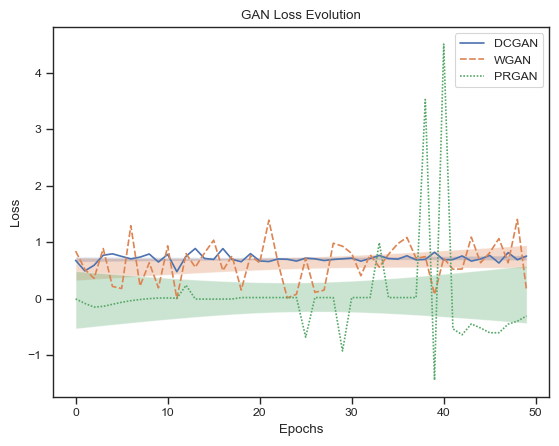

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52]


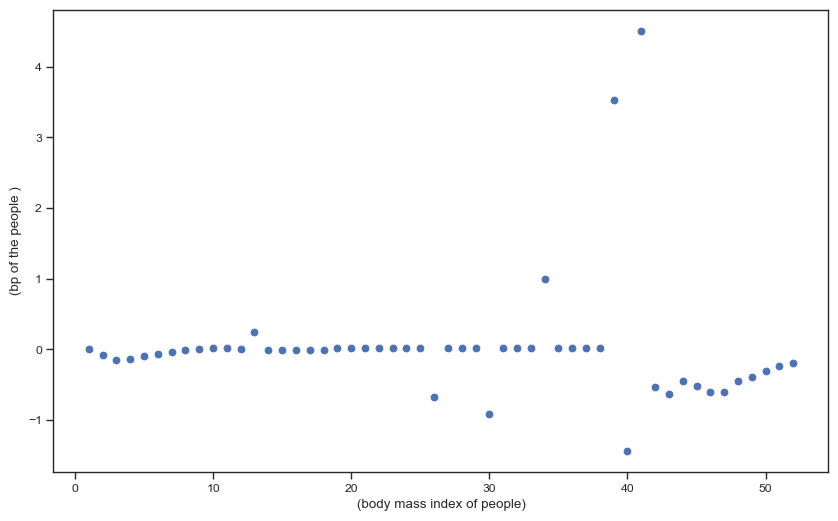

In [117]:
import matplotlib.pyplot as plt
import statsmodels.api as sm

from scipy import stats
import numpy as np
 
def outlier_removal(array):
    if array is not pd.DataFrame:
        array = np.array(array)
        df = pd.DataFrame(array)
    df.head()
    print(df.shape)
    # IQR
    # Calculate the upper and lower limits
    Q1 = df.quantile(0.30)
    Q3 = df.quantile(0.70)
    IQR = Q3 - Q1
    lower = Q1 - 1.5*IQR
    upper = Q3 + 1.5*IQR
    
    # Create arrays of Boolean values indicating the outlier rows
    upper_array = np.where(df>=upper)[0]
    lower_array = np.where(df<=lower)[0]
    
    # Replace outlier values with NaN
    df.iloc[upper_array] = np.nan
    df.iloc[lower_array] = np.nan
    
    # Replace NaN values with the mean
    df = df.fillna(df.mean())
    
    # Print the new shape of the DataFrame
    print("New Shape: ", df.shape)

    return df

df_generator_prgan_loss_values = outlier_removal(generator_prgan_loss_values)
df_generator_prgan_loss_values.rename(columns={df_generator_prgan_loss_values.columns[0]: 'PRGAN'}, inplace=True)

df_generator_wgan_loss_values = outlier_removal(generator_wgan_loss_values)
df_generator_wgan_loss_values.rename(columns={df_generator_wgan_loss_values.columns[0]: 'WGAN'}, inplace=True)

array_generator_dcgan_loss_values = np.array(generator_dcgan_loss_values)
df_generator_dcgan_loss_values = pd.DataFrame(array_generator_dcgan_loss_values, columns=['DCGAN'])


df_combined = pd.concat([df_generator_dcgan_loss_values, df_generator_wgan_loss_values, df_generator_prgan_loss_values[:50]], axis=1)
# Set Seaborn style
sns.set_style("ticks")
sns.set_context("paper")

# Calculate the confidence interval
# Calculate and add the confidence intervals for each line
for column in df_combined.columns:
    model = sm.OLS(df_combined[column], sm.add_constant(df_combined.index))
    results = model.fit()
    predictions = results.get_prediction(sm.add_constant(df_combined.index))
    conf_int = predictions.conf_int(alpha=0.05)
    
    plt.fill_between(df_combined.index, conf_int[:, 0], conf_int[:, 1], alpha=0.3)

sns.lineplot(df_combined, ci='sd', markers=False)

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('GAN Loss Evolution')

# Adding a legend
plt.legend()

# Displaying the plot
plt.show()

output = [i for i in range(1, len(df_generator_prgan_loss_values)+1)]
print(output)
# Scatter plot
fig, ax = plt.subplots(figsize = (10,6))
ax.scatter(output, df_generator_prgan_loss_values)
 
# x-axis label
ax.set_xlabel('(body mass index of people)')
 
# y-axis label
ax.set_ylabel('(bp of the people )')
plt.show()



4/4 [==============================] - 1s 151ms/step
(100, 75, 75, 2)
(75, 75, 2)
(75, 75, 2)
(75, 75, 2)
(75, 75, 2)
(75, 75, 2)
(75, 75, 2)
(75, 75, 2)
(75, 75, 2)
(75, 75, 2)
(75, 75, 2)
(75, 75, 2)
(75, 75, 2)
(75, 75, 2)
(75, 75, 2)
(75, 75, 2)
(75, 75, 2)
(75, 75, 2)
(75, 75, 2)
(75, 75, 2)
(75, 75, 2)
(75, 75, 2)
(75, 75, 2)
(75, 75, 2)
(75, 75, 2)
(75, 75, 2)
(75, 75, 2)
(75, 75, 2)
(75, 75, 2)
(75, 75, 2)
(75, 75, 2)
(75, 75, 2)
(75, 75, 2)
(75, 75, 2)
(75, 75, 2)
(75, 75, 2)
(75, 75, 2)
(75, 75, 2)
(75, 75, 2)
(75, 75, 2)
(75, 75, 2)
(75, 75, 2)
(75, 75, 2)
(75, 75, 2)
(75, 75, 2)
(75, 75, 2)
(75, 75, 2)
(75, 75, 2)
(75, 75, 2)
(75, 75, 2)
(75, 75, 2)
(75, 75, 2)
(75, 75, 2)
(75, 75, 2)
(75, 75, 2)
(75, 75, 2)
(75, 75, 2)
(75, 75, 2)
(75, 75, 2)
(75, 75, 2)
(75, 75, 2)
(75, 75, 2)
(75, 75, 2)
(75, 75, 2)
(75, 75, 2)
(75, 75, 2)
(75, 75, 2)
(75, 75, 2)
(75, 75, 2)
(75, 75, 2)
(75, 75, 2)
(75, 75, 2)
(75, 75, 2)
(75, 75, 2)
(75, 75, 2)
(75, 75, 2)
(75, 75, 2)
(75, 75, 2)
(75, 7

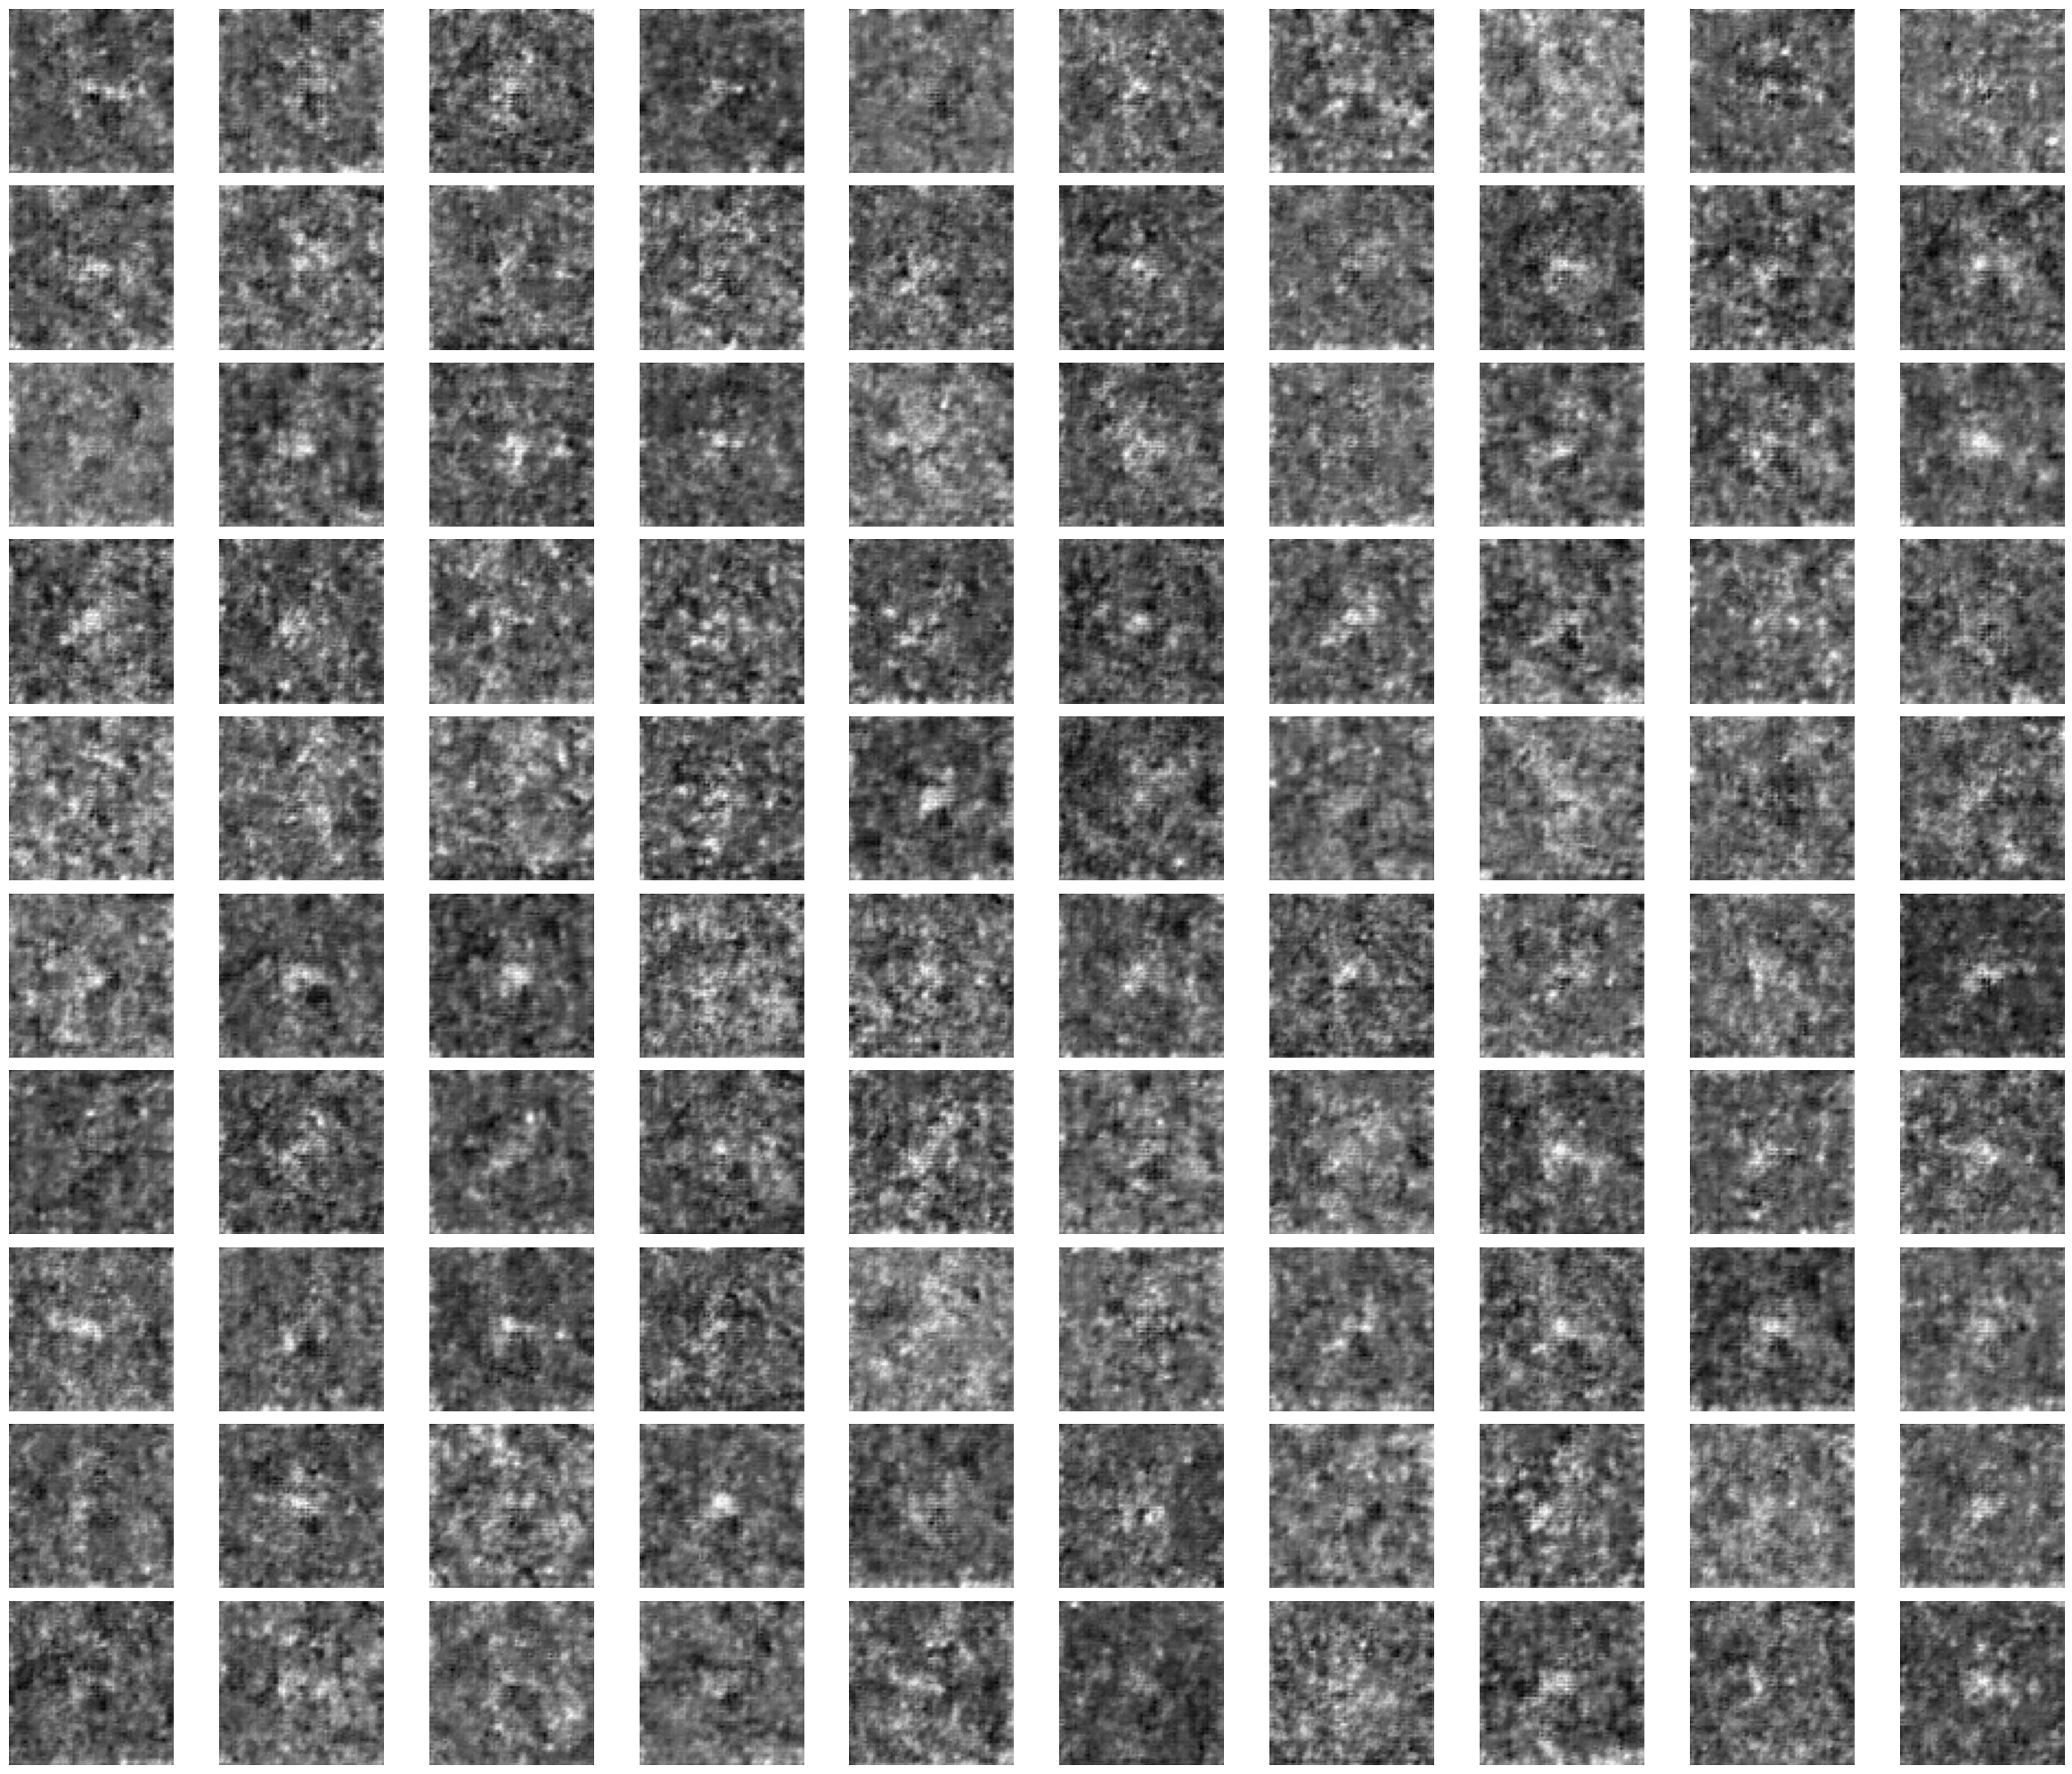

1/1 [==============================] - 1s 737ms/step
(32, 75, 75, 2)
(75, 75, 2)
(75, 75, 2)
(75, 75, 2)
(75, 75, 2)
(75, 75, 2)
(75, 75, 2)
(75, 75, 2)
(75, 75, 2)
(75, 75, 2)
(75, 75, 2)
(75, 75, 2)
(75, 75, 2)
(75, 75, 2)
(75, 75, 2)
(75, 75, 2)
(75, 75, 2)
(75, 75, 2)
(75, 75, 2)
(75, 75, 2)
(75, 75, 2)
(75, 75, 2)
(75, 75, 2)
(75, 75, 2)
(75, 75, 2)
(75, 75, 2)
(75, 75, 2)
(75, 75, 2)
(75, 75, 2)
(75, 75, 2)
(75, 75, 2)
(75, 75, 2)
(75, 75, 2)
(75, 75, 2)
(75, 75, 2)
(75, 75, 2)
(75, 75, 2)
(75, 75, 2)
(75, 75, 2)
(75, 75, 2)
(75, 75, 2)
(75, 75, 2)
(75, 75, 2)
(75, 75, 2)
(75, 75, 2)
(75, 75, 2)
(75, 75, 2)
(75, 75, 2)
(75, 75, 2)
(75, 75, 2)
(75, 75, 2)
(75, 75, 2)
(75, 75, 2)
(75, 75, 2)
(75, 75, 2)
(75, 75, 2)
(75, 75, 2)
(75, 75, 2)
(75, 75, 2)
(75, 75, 2)
(75, 75, 2)
(75, 75, 2)
(75, 75, 2)
(75, 75, 2)
(75, 75, 2)


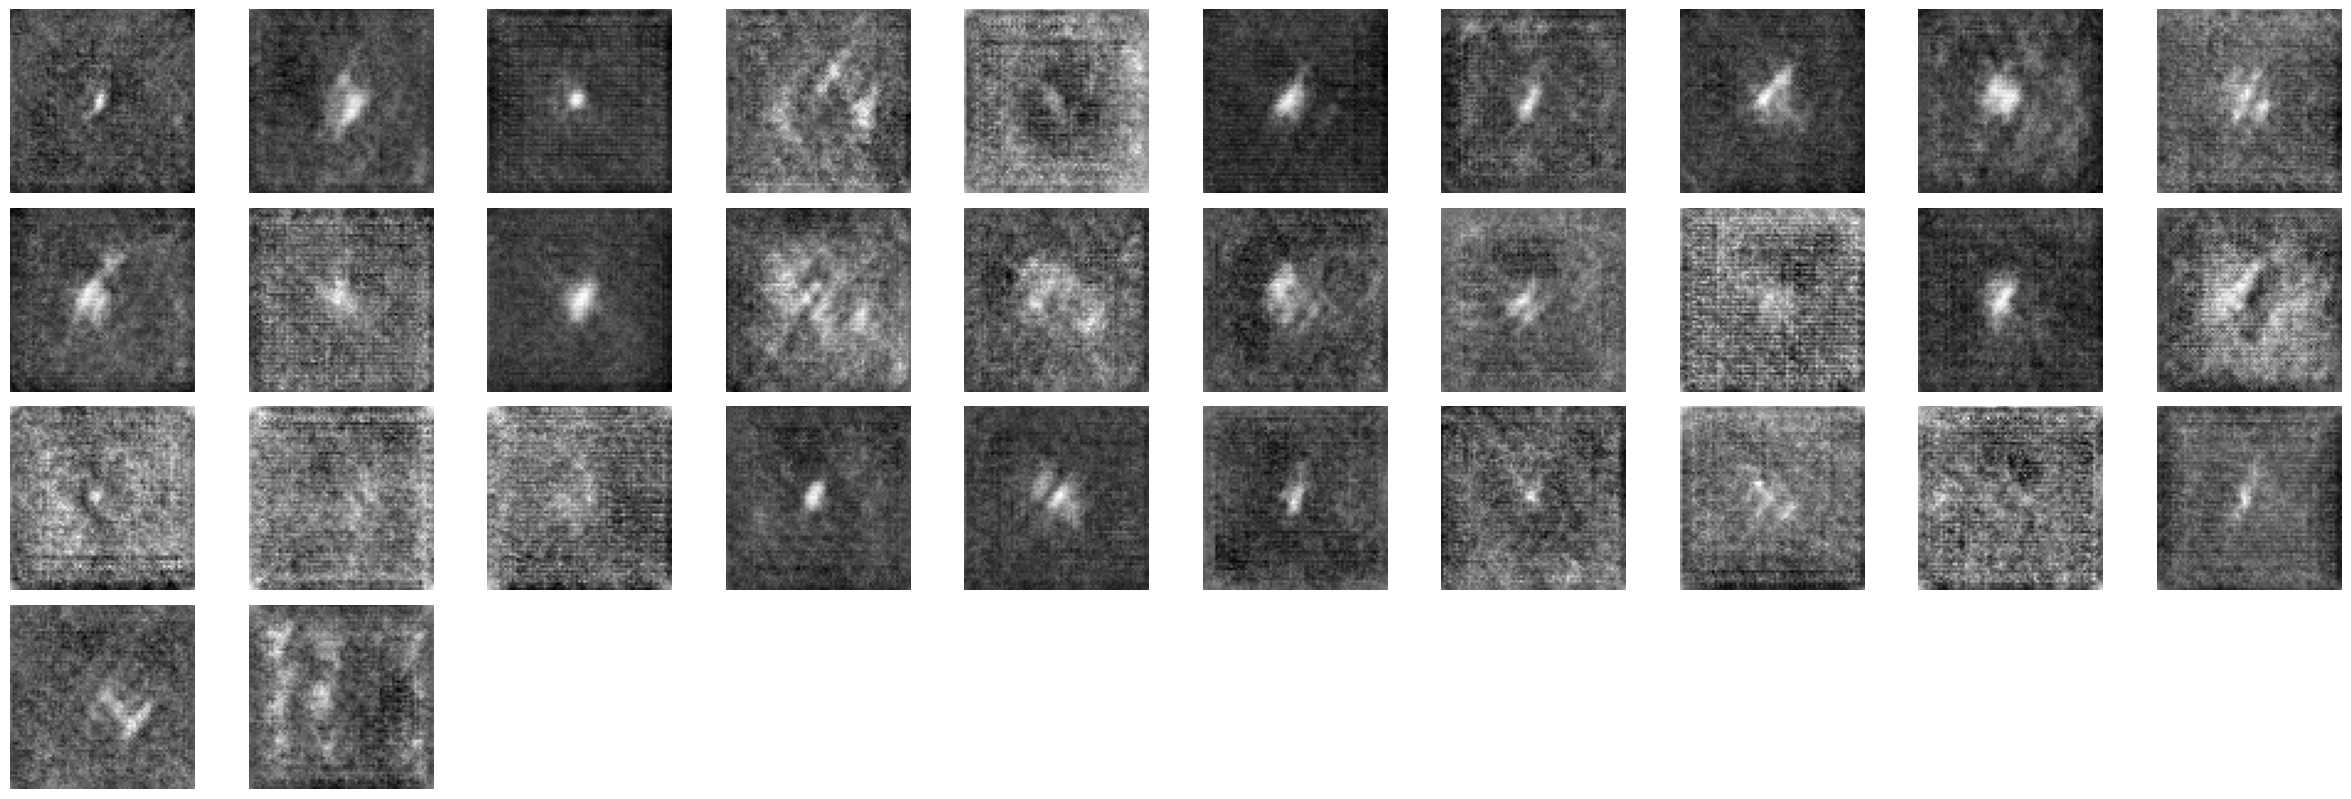

1/1 [==============================] - 0s 49ms/step
(32, 16, 16, 2)
(16, 16, 2)
(75, 75, 2)
(16, 16, 2)
(75, 75, 2)
(16, 16, 2)
(75, 75, 2)
(16, 16, 2)
(75, 75, 2)
(16, 16, 2)
(75, 75, 2)
(16, 16, 2)
(75, 75, 2)
(16, 16, 2)
(75, 75, 2)
(16, 16, 2)
(75, 75, 2)
(16, 16, 2)
(75, 75, 2)
(16, 16, 2)
(75, 75, 2)
(16, 16, 2)
(75, 75, 2)
(16, 16, 2)
(75, 75, 2)
(16, 16, 2)
(75, 75, 2)
(16, 16, 2)
(75, 75, 2)
(16, 16, 2)
(75, 75, 2)
(16, 16, 2)
(75, 75, 2)
(16, 16, 2)
(75, 75, 2)
(16, 16, 2)
(75, 75, 2)
(16, 16, 2)
(75, 75, 2)
(16, 16, 2)
(75, 75, 2)
(16, 16, 2)
(75, 75, 2)
(16, 16, 2)
(75, 75, 2)
(16, 16, 2)
(75, 75, 2)
(16, 16, 2)
(75, 75, 2)
(16, 16, 2)
(75, 75, 2)
(16, 16, 2)
(75, 75, 2)
(16, 16, 2)
(75, 75, 2)
(16, 16, 2)
(75, 75, 2)
(16, 16, 2)
(75, 75, 2)
(16, 16, 2)
(75, 75, 2)
(16, 16, 2)
(75, 75, 2)
(16, 16, 2)
(75, 75, 2)


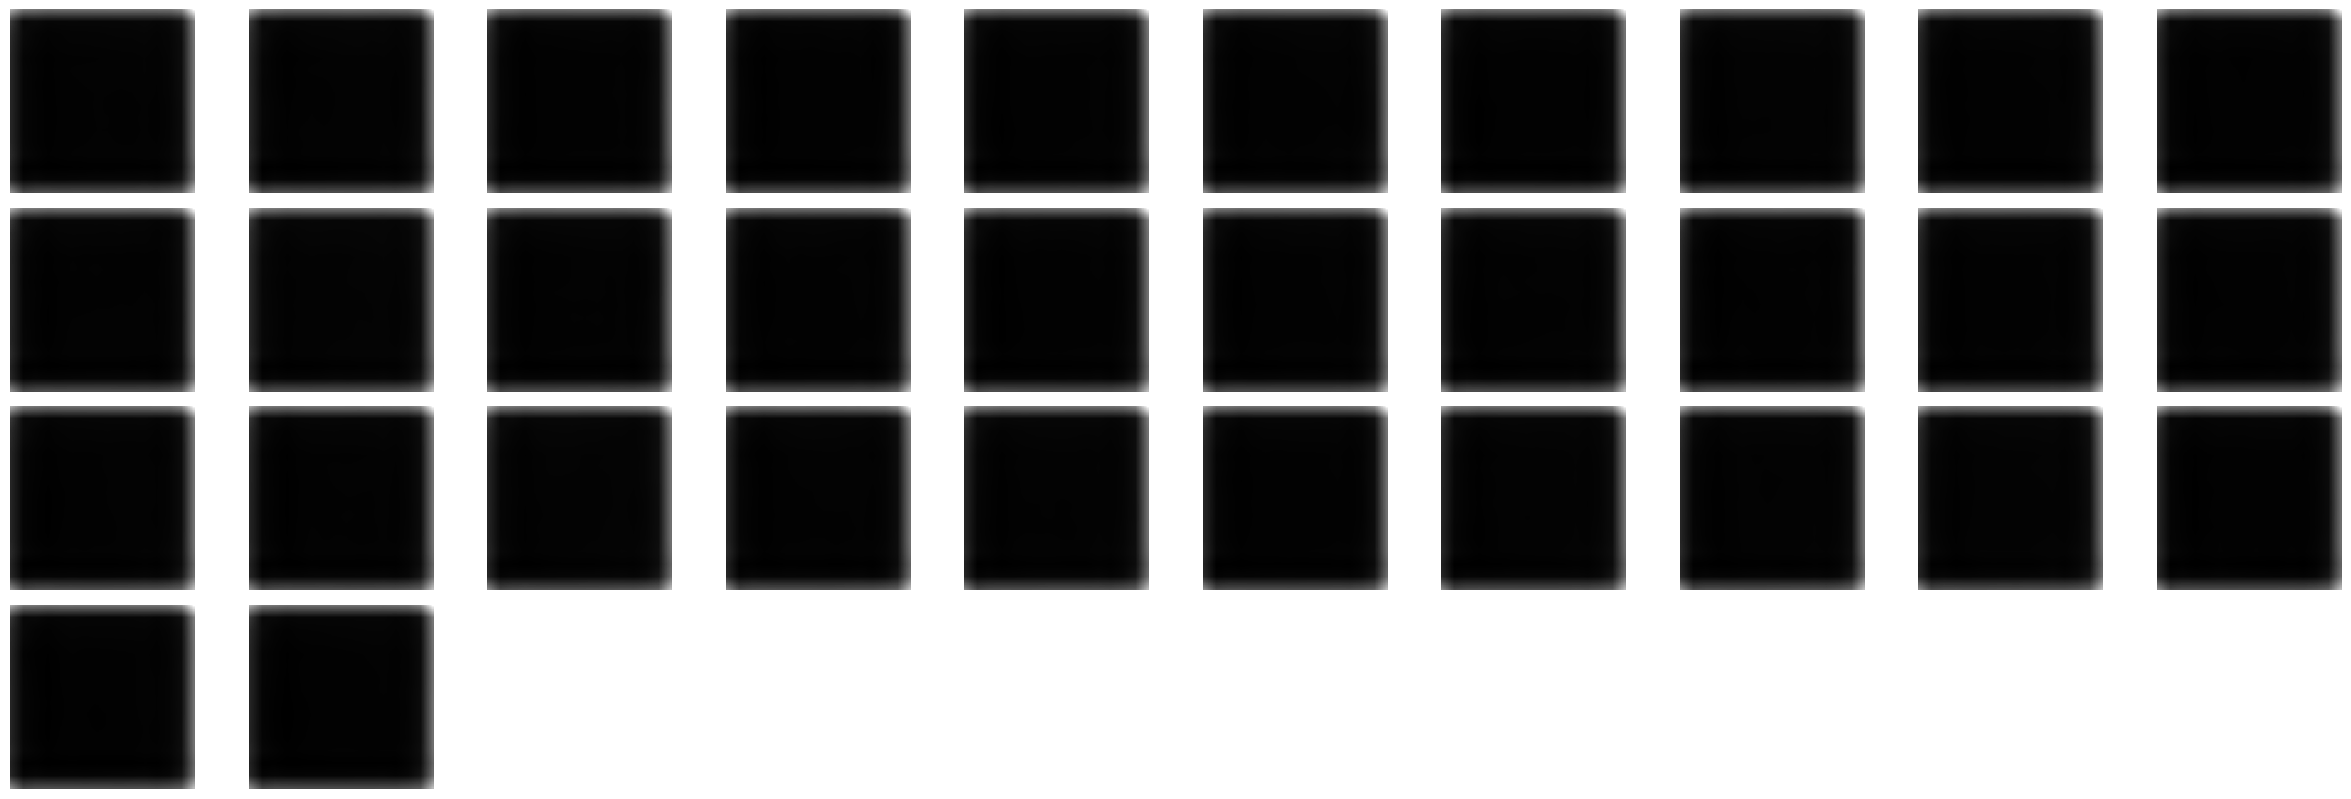

In [165]:
from numpy.random import randn

noise_dcgan = np.random.normal(0, 1, size=(100, NOISE_DIM))
noise_wgan = tf.random.normal([32, 75*75*2])
noise_prgan = randn(100 * 32)
# reshape into a batch of inputs for the network
noise_prgan = noise_prgan.reshape(32, 100)

samples_dcgan = sample_images(noise_dcgan, (10,10), generator_dcgan, 'dcgan', (24,20), save=True)
samples_wgan = sample_images(noise_wgan, (10,10), generator_wgan, 'wgan', (24,20), save=True)
samples_prgan = sample_images(noise_prgan, (10,10), generator_prgan, 'prgan', (24,20), save=True)

In [167]:
samples_dcgan_array = np.array(samples_dcgan)
samples_wgan_array = np.array(samples_wgan)
samples_prgan_array = np.array(samples_prgan)
X_train_array = np.array(X_train)

samples_dcgan_array = preprocess_array(samples_dcgan_array)
samples_wgan_array = preprocess_array(samples_wgan_array)
samples_prgan_array = preprocess_array(samples_prgan_array)
X_train_array = preprocess_array(X_train_array)



In [158]:
!pip install opencv-python


[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: C:\Users\flopes1\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [196]:
import scores
importlib.reload(scores) 
from scores import scores, calculate_bhattacharyya, calculate_chi_square


#print(X_train_array[:30].shape)
#print(samples_dcgan_array[:30].shape)
#fid, fid_error, bc, bc_error, chi_square, chi_square_error, correlation, correlation_error, intersection, intersection_error
#    return fid, fid_error, bhattacharyya, bhattacharyya_error, chi_square, chi_square_error, correlation, correlation_error, intersection, intersection_error

dcgan_fid, dcgan_fid_error, dcgan_bc, dcgan_bc_error, dcgan_cs, dcgan_cs_error, dcgan_corr, dcgan_corr_error, dcgan_inter, dcgan_inter_error = scores(X_train_array[:30], samples_dcgan_array[:30])
wgan_fid, wgan_fid_error, wgan_bc, wgan_bc_error, wgan_cs, wgan_cs_error, wgan_corr, wgan_corr_error, wgan_inter, wgan_inter_error = scores(X_train_array[:30], samples_wgan_array[:30])
prgan_fid, prgan_fid_error, prgan_bc, prgan_bc_error, prgan_cs, prgan_cs_error, prgan_corr, prgan_corr_error, prgan_inter, prgan_inter_error = scores(X_train_array[:30], samples_prgan_array[:30])

# TODO: ADD THE COMPARISON WITH THE REAL IMAGES ITSELF


1/1 [==============================] - 0s 98ms/step
Bhattacharyya started...
Bhattacharyya done.
Chi-square started...
Chi-square done.
Correlation started...
Correlation done.
Done!
1/1 [==============================] - 0s 99ms/step
Bhattacharyya started...
Bhattacharyya done.
Chi-square started...
Chi-square done.
Correlation started...
Correlation done.
Done!
1/1 [==============================] - 0s 103ms/step
Bhattacharyya started...
Bhattacharyya done.
Chi-square started...
Chi-square done.
Correlation started...
Correlation done.
Done!


[0.8083417186332975, 1.0258652641495856, 4.544035014924508]
[0.9964027158488561, 0.9919154010464376, 0.9835918147152102]
[1010.2053107626809, 2057.970326914817, 2839.1525107486473]
[2.250065957337593e-05, 0.00010928659708435736, 8.441386931233992e-05]
[2.9411764705882355e-06, 0.0001013605345799262, 0.0]


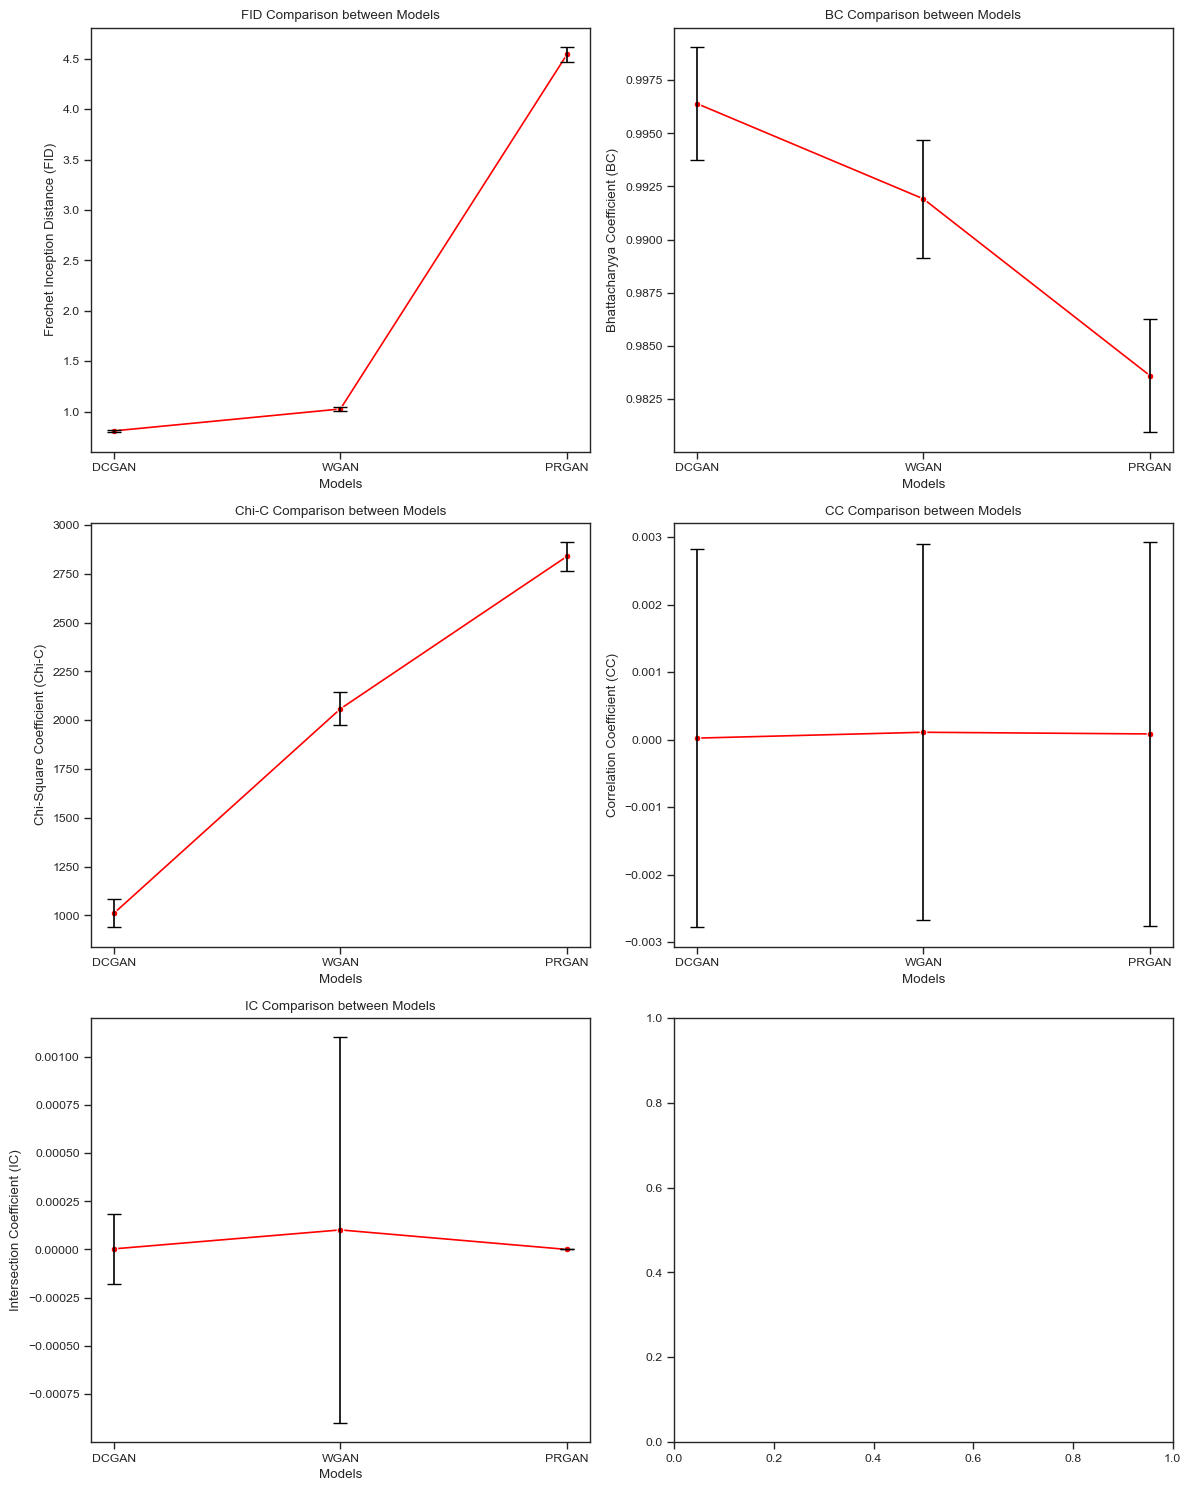

In [199]:
# Data for FID comparison
model_names = ['DCGAN', 'WGAN', 'PRGAN']
fid_means = [dcgan_fid/1000, wgan_fid/1000, prgan_fid/1000]
fid_errors = [dcgan_fid_error/1000, wgan_fid_error/1000, prgan_fid_error/1000]
print(fid_means)

bc_means = [dcgan_bc, wgan_bc, prgan_bc]
bc_errors = [dcgan_bc_error, wgan_bc_error, prgan_bc_error]
print(bc_means)

cs_means = [dcgan_cs, wgan_cs, prgan_cs]
cs_errors = [dcgan_cs_error, wgan_cs_error, prgan_cs_error]
print(cs_means)

corr_means = [dcgan_corr, wgan_corr, prgan_corr]
corr_errors = [dcgan_corr_error, wgan_bc_error, prgan_corr_error]
print(corr_means)

inter_means = [dcgan_inter, wgan_inter, prgan_inter]
inter_errors = [dcgan_inter_error, wgan_inter_error, prgan_inter_error]
print(inter_means)

# Create a figure with five subplots
fig, ((ax1, ax2), (ax3, ax4), (ax5, _)) = plt.subplots(3, 2, figsize=(12, 15))

# Plotting the FID comparison using a line chart with error bars
sns.lineplot(x=model_names, y=fid_means, marker='o', color='red', ax=ax1)
ax1.errorbar(x=model_names, y=fid_means, yerr=fid_errors, fmt='none', color='black', capsize=5)
ax1.set_xlabel('Models')
ax1.set_ylabel('Frechet Inception Distance (FID)')
ax1.set_title('FID Comparison between Models')

# Plotting the BC comparison using a line chart with error bars
sns.lineplot(x=model_names, y=bc_means, marker='o', color='red', ax=ax2)
ax2.errorbar(x=model_names, y=bc_means, yerr=bc_errors, fmt='none', color='black', capsize=5)
ax2.set_xlabel('Models')
ax2.set_ylabel('Bhattacharyya Coefficient (BC)')
ax2.set_title('BC Comparison between Models')

# Plotting the Chi-Square comparison using a line chart with error bars
sns.lineplot(x=model_names, y=cs_means, marker='o', color='red', ax=ax3)
ax3.errorbar(x=model_names, y=cs_means, yerr=cs_errors, fmt='none', color='black', capsize=5)
ax3.set_xlabel('Models')
ax3.set_ylabel('Chi-Square Coefficient (Chi-C)')
ax3.set_title('Chi-C Comparison between Models')

# Plotting the Correlation comparison using a line chart with error bars
sns.lineplot(x=model_names, y=corr_means, marker='o', color='red', ax=ax4)
ax4.errorbar(x=model_names, y=corr_means, yerr=corr_errors, fmt='none', color='black', capsize=5)
ax4.set_xlabel('Models')
ax4.set_ylabel('Correlation Coefficient (CC)')
ax4.set_title('CC Comparison between Models')

# Plotting the Intersection comparison using a line chart with error bars
sns.lineplot(x=model_names, y=inter_means, marker='o', color='red', ax=ax5)
ax5.errorbar(x=model_names, y=inter_means, yerr=inter_errors, fmt='none', color='black', capsize=5)
ax5.set_xlabel('Models')
ax5.set_ylabel('Intersection Coefficient (IC)')
ax5.set_title('IC Comparison between Models')


# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()